In [1]:
!pip install umap-learn
import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
from sklearn.manifold import TSNE
from torch import Tensor
from typing import Type
import torch.nn.init as init
from google.colab import drive
drive.mount('/content/drive')

# Transformaciones para entrenamiento y validación
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),  # Recorte aleatorio después del padding
    torchvision.transforms.RandomHorizontalFlip(),      # Volteo horizontal aleatorio
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Cargar datasets CIFAR-10 con transformaciones
train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=train_transform  # Se aplica data augmentation aquí
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=val_test_transform  # Solo normalización para testing
)

# Dividir dataset de entrenamiento y validación
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="./cifar10", train=True, transform=val_test_transform),
    [45000, 5000], generator=torch.Generator().manual_seed(42)
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00
Mounted at /content/drive


100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


# Resnet Modulo Gen

In [2]:

__all__ = ['resnet110']
def _weights_init(m):
    """
        Initialization of CNN weights
    """
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    """
      Identity mapping between ResNet blocks with diffrenet size feature map
    """
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 experiment, ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        feature_maps['ReLUconv1'] = out
        out = self.layer1(out)
        out = self.layer2(out)
        feature_maps['Layer2'] = out
        out = self.layer3(out)
        feature_maps['Layer3'] = out
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out


## Resnet 110

In [3]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])
model = resnet110()
for name, param in model.named_parameters():
    print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.3.conv1.weight
layer1.3.bn1.weight
layer1.3.bn1.bias
layer1.3.conv2.weight
layer1.3.bn2.weight
layer1.3.bn2.bias
layer1.4.conv1.weight
layer1.4.bn1.weight
layer1.4.bn1.bias
layer1.4.conv2.weight
layer1.4.bn2.weight
layer1.4.bn2.bias
layer1.5.conv1.weight
layer1.5.bn1.weight
layer1.5.bn1.bias
layer1.5.conv2.weight
layer1.5.bn2.weight
layer1.5.bn2.bias
layer1.6.conv1.weight
layer1.6.bn1.weight
layer1.6.bn1.bias
layer1.6.conv2.weight
layer1.6.bn2.weight
layer1.6.bn2.bias
layer1.7.conv1.weight
layer1.7.bn1.weight
layer1.7.bn1.bias
layer1.7.conv2.weight
layer1.7.bn2.weight
layer1.7.bn2.bias
layer1.

In [ ]:
def show_gradients_ResNet_110(model):
    layers_to_show = ['layer1.0.conv1', 'layer1.0.bn1', 'layer2.8.conv1', 'layer2.8.bn1', 'linear']  # Capas inicial, intermedia y final
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().numpy()
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")
            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')
            plt.show()

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    # Asegúrate de que los datos estén en la CPU antes de convertirlos a NumPy
    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, np.array(curves['val_loss']), label='validation')
    ax[0].plot(epochs, np.array(curves['train_loss']), label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, np.array(curves['val_acc']), label='validation')
    ax[1].plot(epochs, np.array(curves['train_acc']), label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

# Visualize feature maps
def show_feature_maps(feature_maps):
    for layer_name, feature_map in feature_maps.items():
        fmap = feature_map[0].cpu().numpy()  # Convert to CPU and NumPy for visualization
        num_feature_maps = fmap.shape[0]

        # Plot a grid of feature maps (first 8 feature maps)
        fig, axes = plt.subplots(1, min(8, num_feature_maps), figsize=(20, 5))
        fig.suptitle(f"Feature Maps from Layer {layer_name}", fontsize=16)

        for i in range(min(8, num_feature_maps)):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')

        plt.show()

def checkpoint_save(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint guardado en {os.path.join(checkpoint_dir, filename)}")

def checkpoint_resume(model, optimizer, filename):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        epoch = checkpoint_data['epoch']
        print(f"Checkpoint cargado desde '{checkpoint_path}' (época {epoch})")
        return epoch
    else:
        print(f"No se encontró ningún checkpoint en '{checkpoint_path}'")
        return None

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, device):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_predicted = model(x_batch)
    loss = criterion(y_predicted, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_predicted, loss

# Evaluation function
def evaluate(val_loader, model, criterion, device):
    model.eval()
    cumulative_loss = 0
    cumulative_corrects = 0
    data_count = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            final_output = model(imgs)
            loss = criterion(final_output, labels)
            cumulative_loss += loss.item() * len(labels)
            data_count += len(labels)
            _, pred_class = final_output.max(1)
            cumulative_corrects += (pred_class == labels).sum().item()
    val_acc = cumulative_corrects / data_count
    val_loss = cumulative_loss / data_count
    return val_acc, val_loss

#Segunda Resnet
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    weight_decay,
    n_evaluations_per_epoch,
    early_stop_thresh,  # Early stopping threshold
    show_gradients,
    patience,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ])
    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")


    # Usar GPU si está disponible
    device = torch.device('cuda' if use_gpu else 'cpu')
    model = model.to(device)

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4,pin_memory=use_gpu)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.0001, threshold_mode='abs')
    scaler = torch.amp.GradScaler()

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)
    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = checkpoint_resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    best_val_loss = float('inf')
    best_epoch = -1
    early_stop_counter = 0

    for epoch in range(start_epoch, epochs):
        print(optimizer.param_groups[0]["lr"])
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, device)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Accuracy calculation
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


            # Registro de métricas
            if (i + 1) % (n_batches // n_evaluations_per_epoch) == 0:
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(
                    f"Iteración {iteration + 1} - Lote {i + 1}/{n_batches} - "
                    f"Pérdida de Entrenamiento: {train_loss:.4f}, Precisión de Entrenamiento: {train_acc:.4f}"
                )


            iteration += 1
            if iteration >= max_iterations:
                print(f"Número máximo de iteraciones alcanzado: {max_iterations}")
                break

        val_acc, val_loss = evaluate(val_loader, model, criterion, device)
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        scheduler.step(val_loss)

        # Checkpointing the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
            checkpoint_filename = f"best_checkpoint_epoch_{epoch + 1}.pth"
            checkpoint_save(model, optimizer, epoch, checkpoint_filename)
            print(f"Checkpoint del mejor modelo guardado en la época {epoch + 1}")
        else:
            early_stop_counter += 1

        if epoch + 1 == 1 or (epoch + 1) % 5 == 0 or early_stop_counter >= early_stop_thresh:
            show_gradients(model)
            show_feature_maps(feature_maps)

        if early_stop_counter >= early_stop_thresh:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if iteration >= max_iterations:
            break

    total_time = time.perf_counter() - t0
    print(f"\nTiempo total de entrenamiento: {total_time:.2f} segundos")

    # Ensure the model is on CPU after training
    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

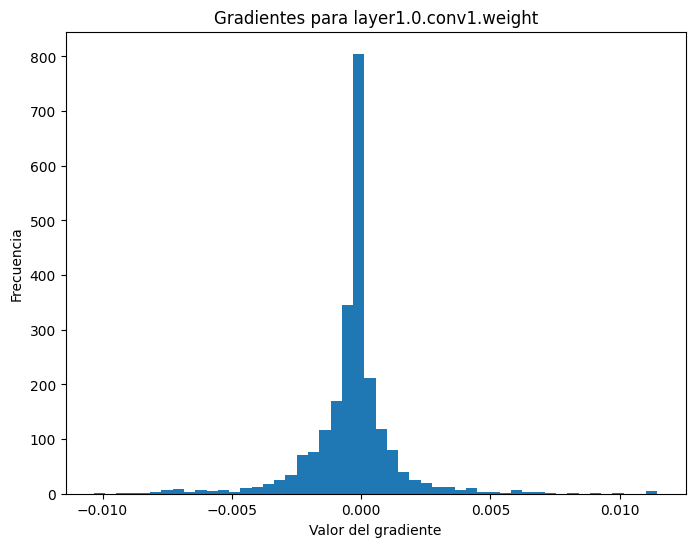

Gradientes para layer1.0.bn1.weight: min=-0.03297162428498268, max=0.019082123413681984, mean=-0.00019410368986427784, std=0.011311423033475876


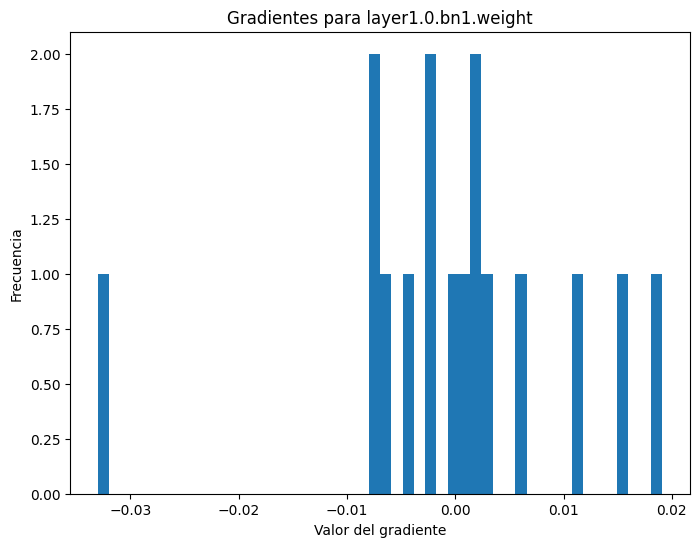

Gradientes para layer1.0.bn1.bias: min=-0.02953414060175419, max=0.02086416259407997, mean=0.002108665183186531, std=0.01114095002412796


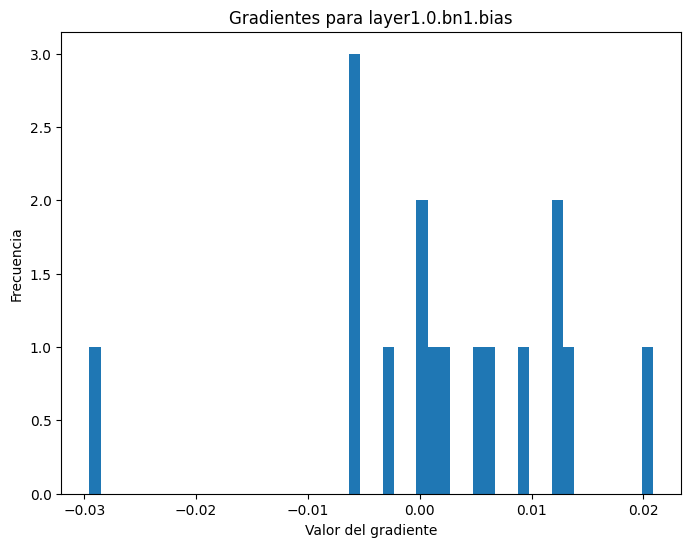

Gradientes para layer2.8.conv1.weight: min=-0.006809278856962919, max=0.0034333537332713604, mean=-3.709890734171495e-05, std=0.0003445484035182744


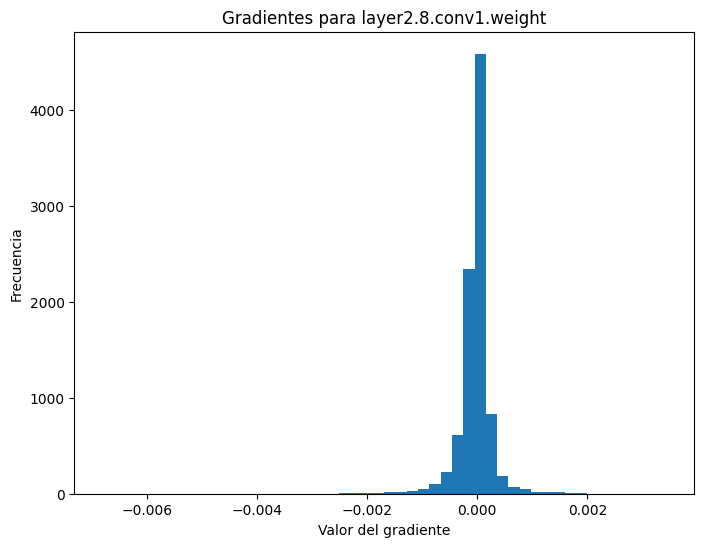

Gradientes para layer2.8.bn1.weight: min=-0.002260240726172924, max=0.0011407004203647375, mean=-2.963402948807925e-06, std=0.0006117051816545427


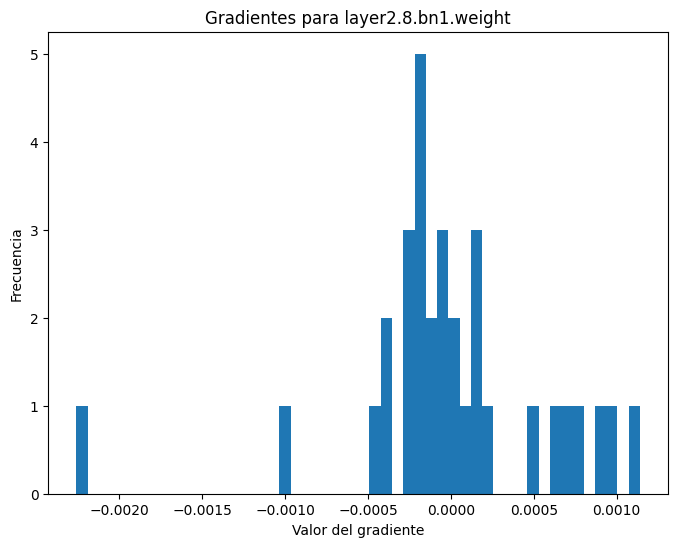

Gradientes para layer2.8.bn1.bias: min=-0.002734549343585968, max=0.0026974009815603495, mean=-0.0001482871302869171, std=0.0011500437976792455


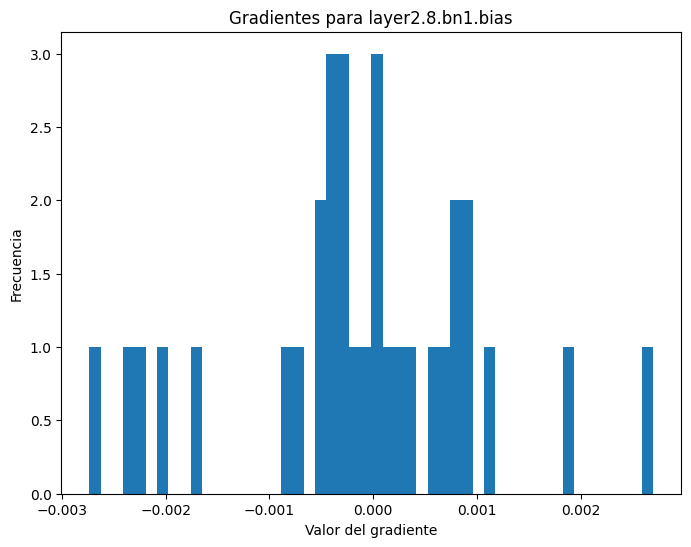

Gradientes para linear.weight: min=-0.1805957704782486, max=0.2026611864566803, mean=6.984919587171845e-11, std=0.015528170391917229


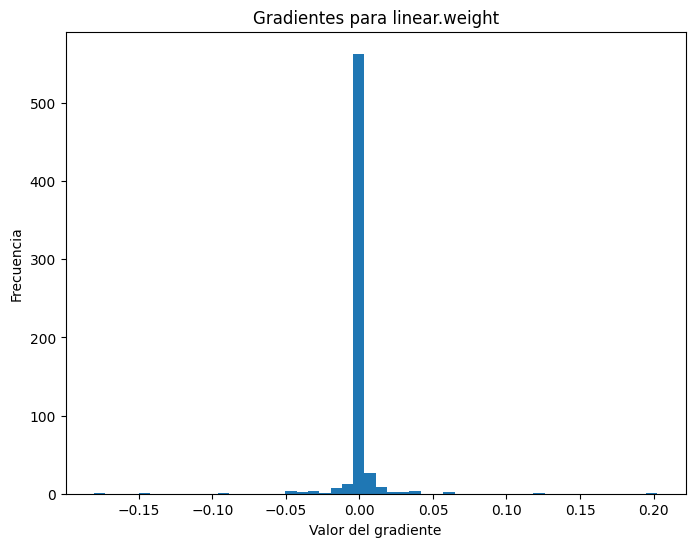

Gradientes para linear.bias: min=-0.07406958937644958, max=0.07189201563596725, mean=-2.2351742678949904e-09, std=0.052424248307943344


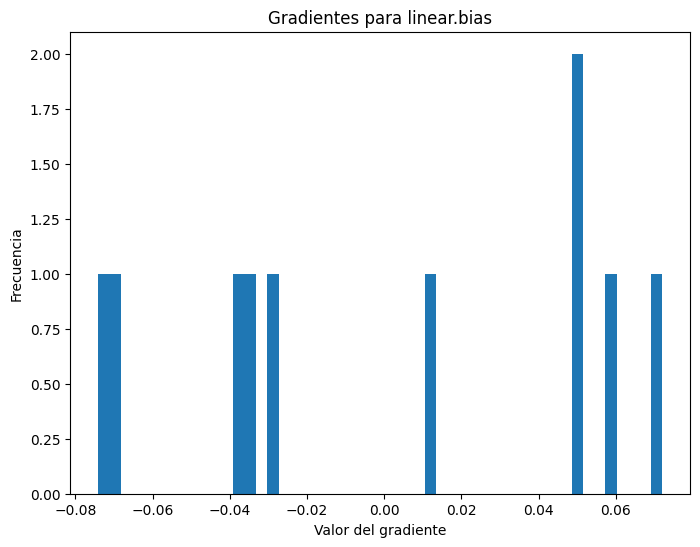

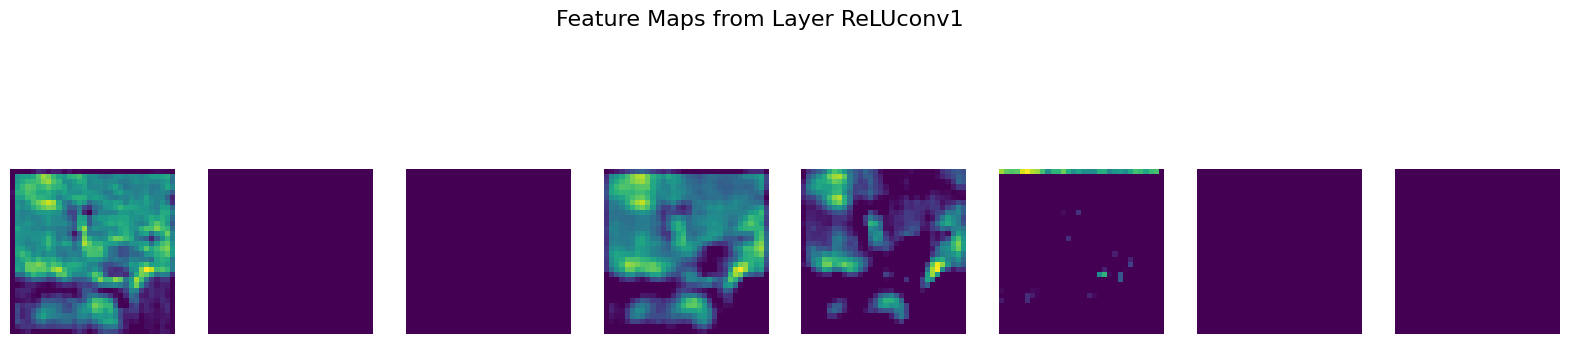

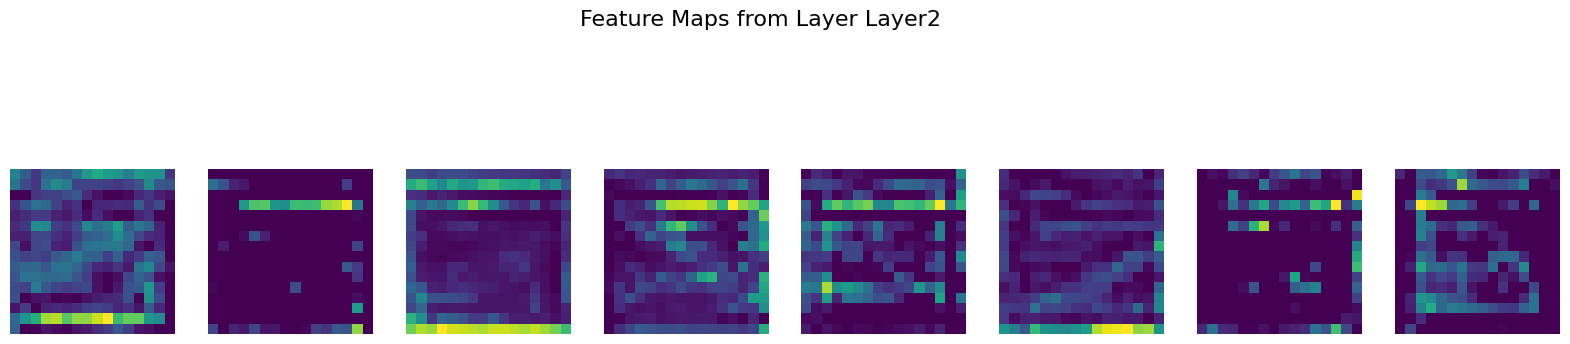

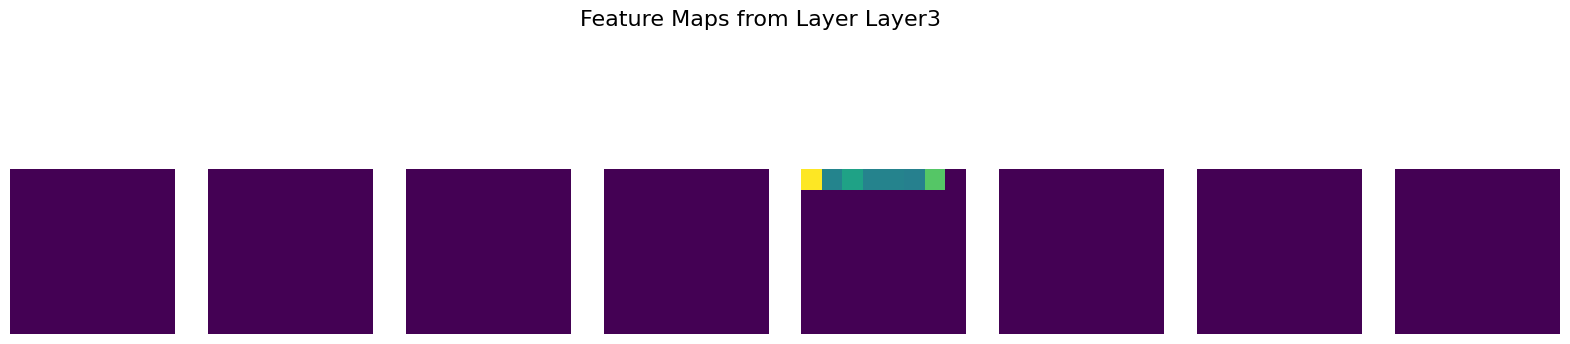

0.04
Epoch 2/70
Iteración 387 - Lote 35/352 - Pérdida de Entrenamiento: 1.9965, Precisión de Entrenamiento: 0.2172
Iteración 422 - Lote 70/352 - Pérdida de Entrenamiento: 1.9850, Precisión de Entrenamiento: 0.2271
Iteración 457 - Lote 105/352 - Pérdida de Entrenamiento: 1.9701, Precisión de Entrenamiento: 0.2321
Iteración 492 - Lote 140/352 - Pérdida de Entrenamiento: 1.9628, Precisión de Entrenamiento: 0.2364
Iteración 527 - Lote 175/352 - Pérdida de Entrenamiento: 1.9464, Precisión de Entrenamiento: 0.2448
Iteración 562 - Lote 210/352 - Pérdida de Entrenamiento: 1.9309, Precisión de Entrenamiento: 0.2522
Iteración 597 - Lote 245/352 - Pérdida de Entrenamiento: 1.9141, Precisión de Entrenamiento: 0.2606
Iteración 632 - Lote 280/352 - Pérdida de Entrenamiento: 1.8988, Precisión de Entrenamiento: 0.2664
Iteración 667 - Lote 315/352 - Pérdida de Entrenamiento: 1.8840, Precisión de Entrenamiento: 0.2730
Iteración 702 - Lote 350/352 - Pérdida de Entrenamiento: 1.8695, Precisión de Entrenam

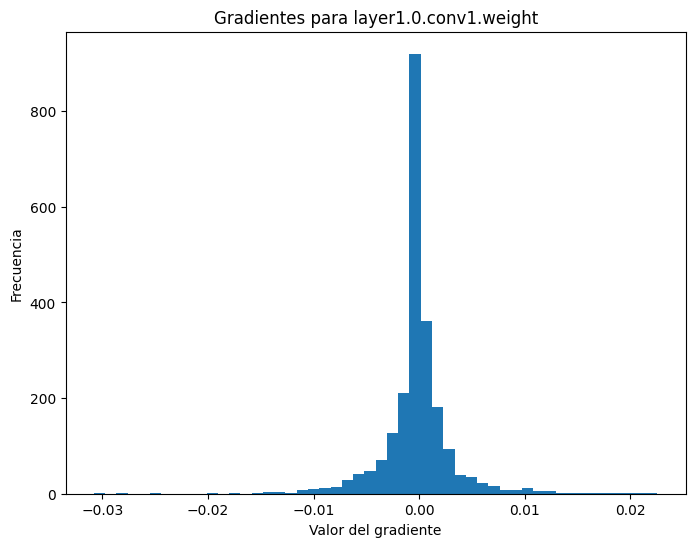

Gradientes para layer1.0.bn1.weight: min=-0.02484070509672165, max=0.01882544346153736, mean=-0.001067913486622274, std=0.011216813698410988


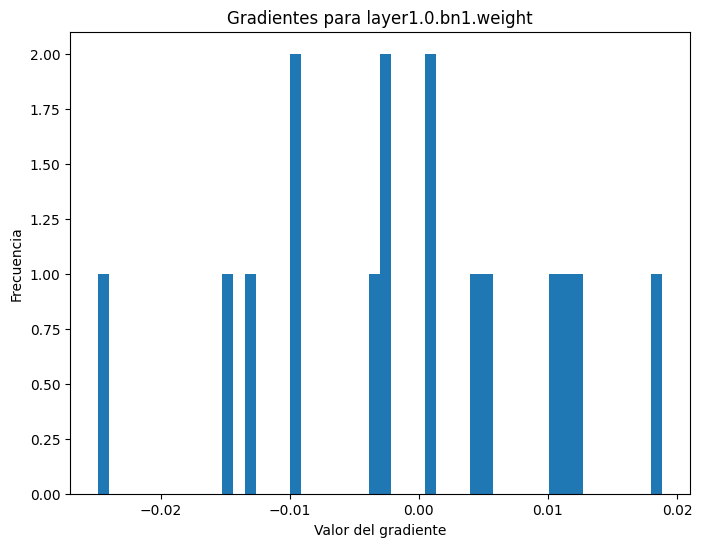

Gradientes para layer1.0.bn1.bias: min=-0.01714615523815155, max=0.024355748668313026, mean=-0.001730145886540413, std=0.0115470876917243


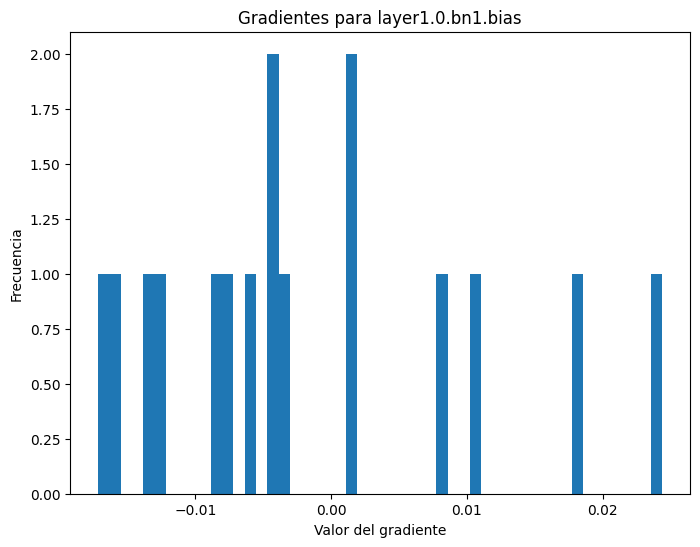

Gradientes para layer2.8.conv1.weight: min=-0.010027548298239708, max=0.010014565661549568, mean=-3.98773918277584e-05, std=0.001255280920304358


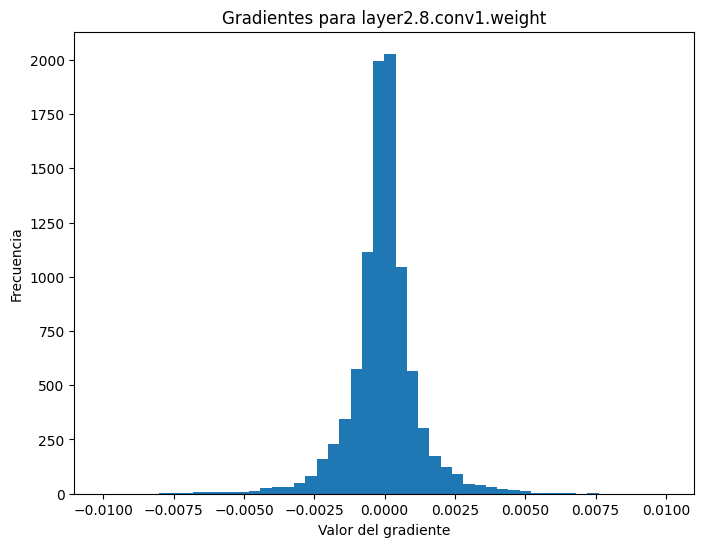

Gradientes para layer2.8.bn1.weight: min=-0.00435979850590229, max=0.003853118745610118, mean=-5.953392246738076e-06, std=0.0019100813660770655


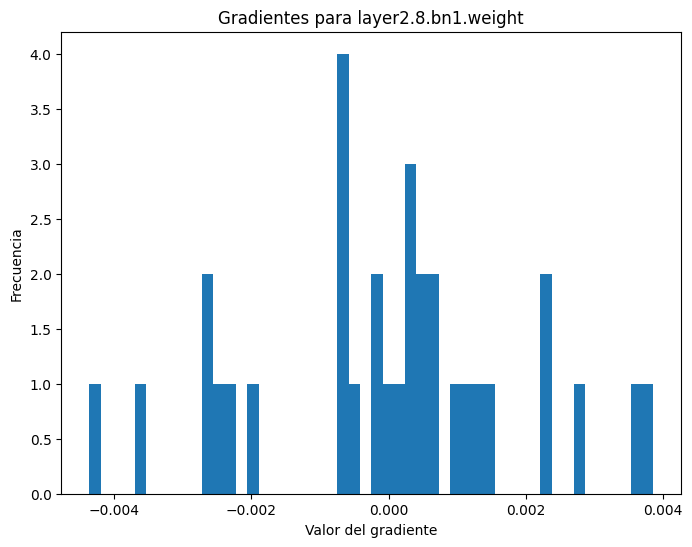

Gradientes para layer2.8.bn1.bias: min=-0.009069488383829594, max=0.006080470979213715, mean=4.069754504598677e-05, std=0.003553982125595212


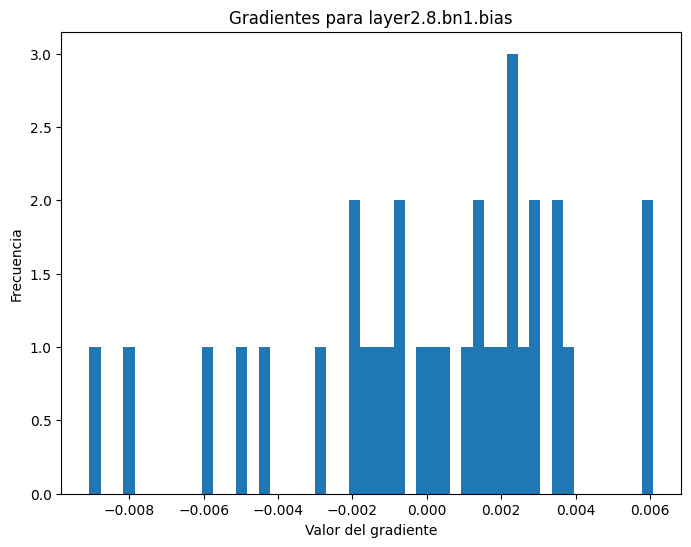

Gradientes para linear.weight: min=-0.20674191415309906, max=0.12797582149505615, mean=3.7252903539730653e-10, std=0.023521676659584045


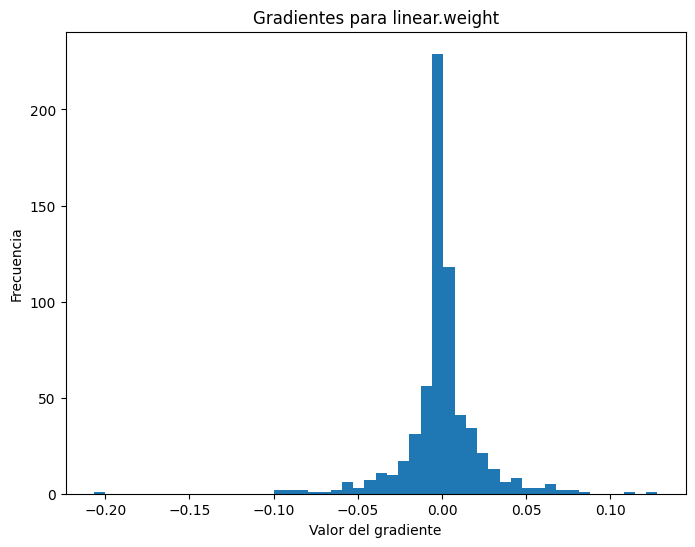

Gradientes para linear.bias: min=-0.061181358993053436, max=0.04838929697871208, mean=9.313225746154785e-10, std=0.037248022854328156


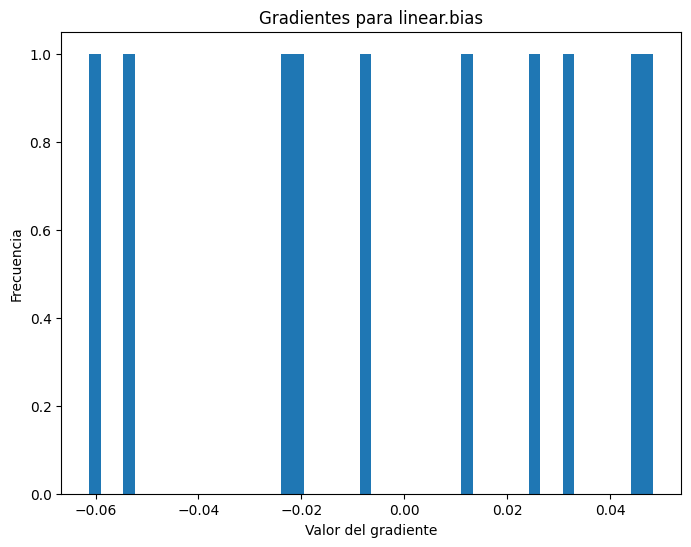

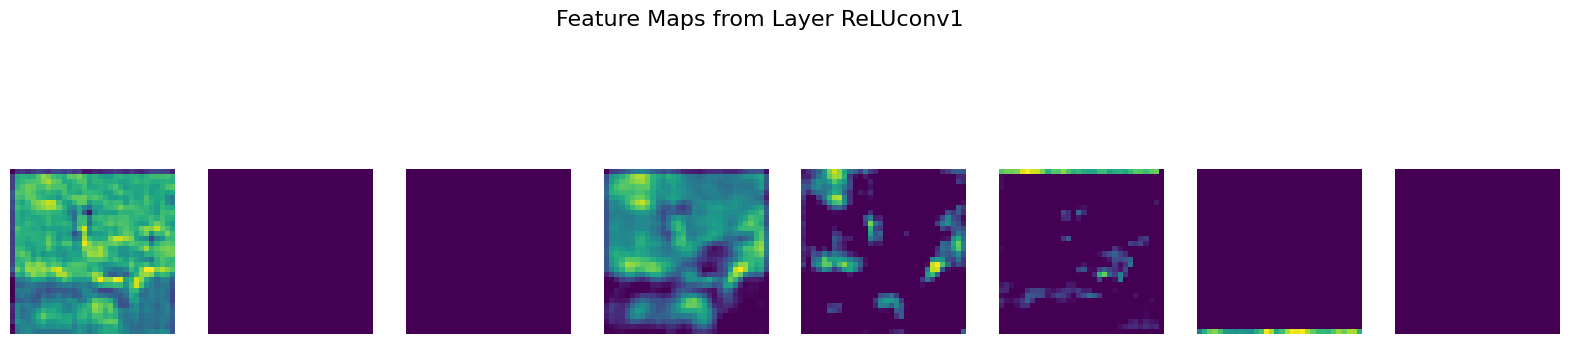

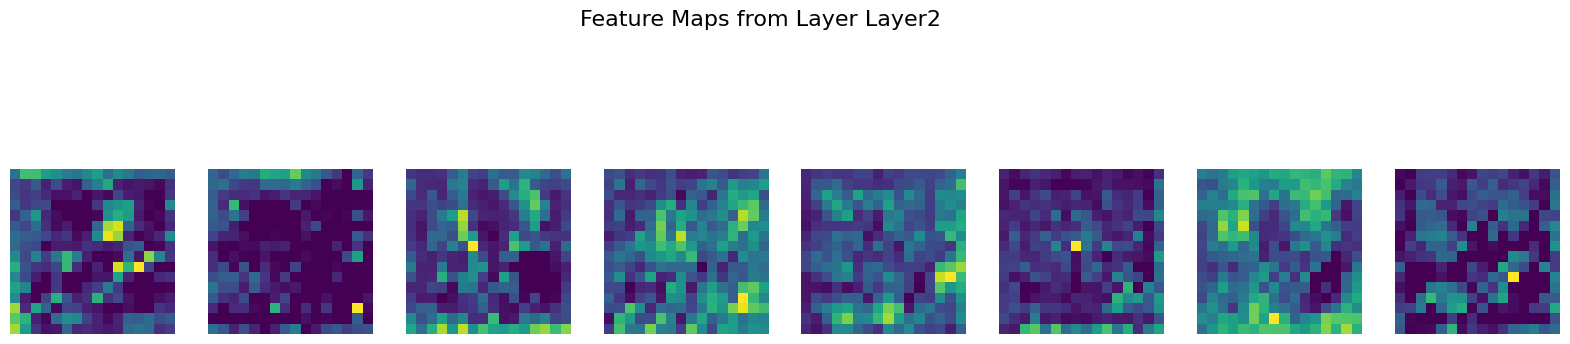

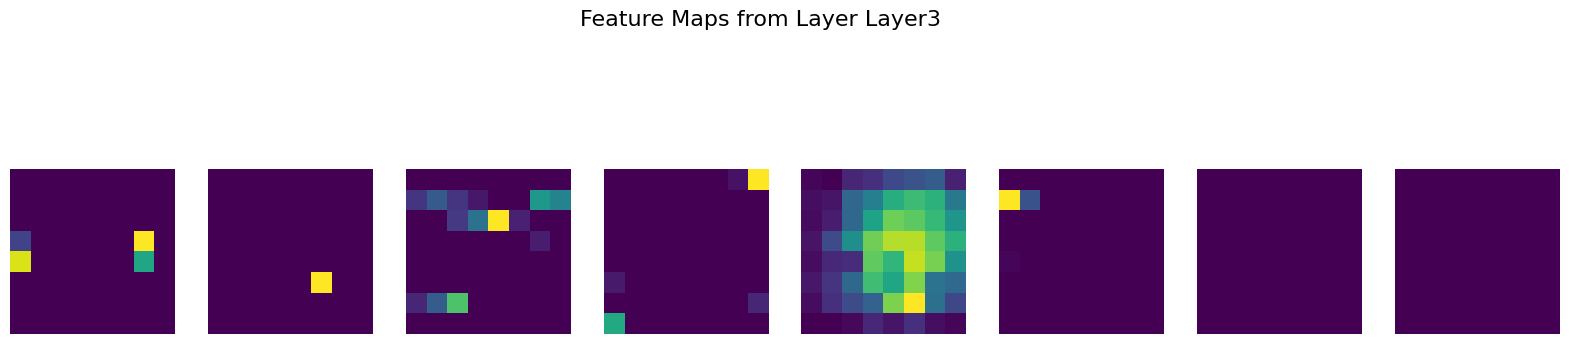

0.04
Epoch 6/70
Iteración 1795 - Lote 35/352 - Pérdida de Entrenamiento: 0.9545, Precisión de Entrenamiento: 0.6545
Iteración 1830 - Lote 70/352 - Pérdida de Entrenamiento: 0.9680, Precisión de Entrenamiento: 0.6520
Iteración 1865 - Lote 105/352 - Pérdida de Entrenamiento: 0.9643, Precisión de Entrenamiento: 0.6539
Iteración 1900 - Lote 140/352 - Pérdida de Entrenamiento: 0.9505, Precisión de Entrenamiento: 0.6610
Iteración 1935 - Lote 175/352 - Pérdida de Entrenamiento: 0.9446, Precisión de Entrenamiento: 0.6631
Iteración 1970 - Lote 210/352 - Pérdida de Entrenamiento: 0.9382, Precisión de Entrenamiento: 0.6658
Iteración 2005 - Lote 245/352 - Pérdida de Entrenamiento: 0.9333, Precisión de Entrenamiento: 0.6681
Iteración 2040 - Lote 280/352 - Pérdida de Entrenamiento: 0.9255, Precisión de Entrenamiento: 0.6707
Iteración 2075 - Lote 315/352 - Pérdida de Entrenamiento: 0.9201, Precisión de Entrenamiento: 0.6727
Iteración 2110 - Lote 350/352 - Pérdida de Entrenamiento: 0.9124, Precisión d

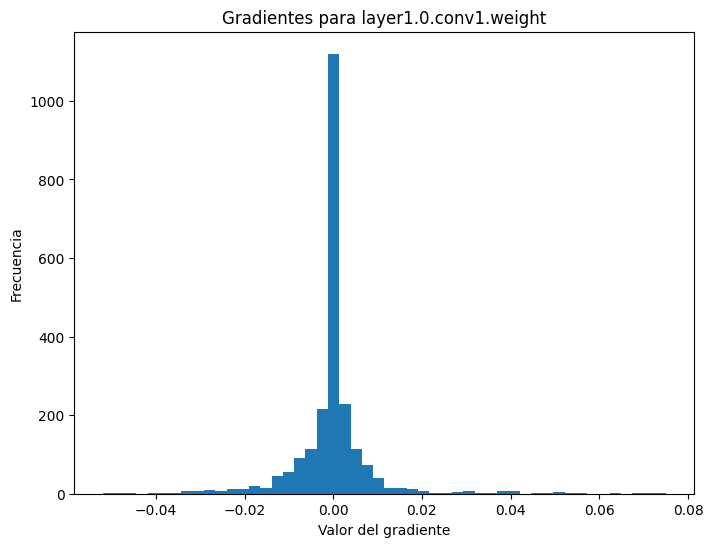

Gradientes para layer1.0.bn1.weight: min=-0.05889703705906868, max=0.05750618875026703, mean=-0.0030846851877868176, std=0.027864407747983932


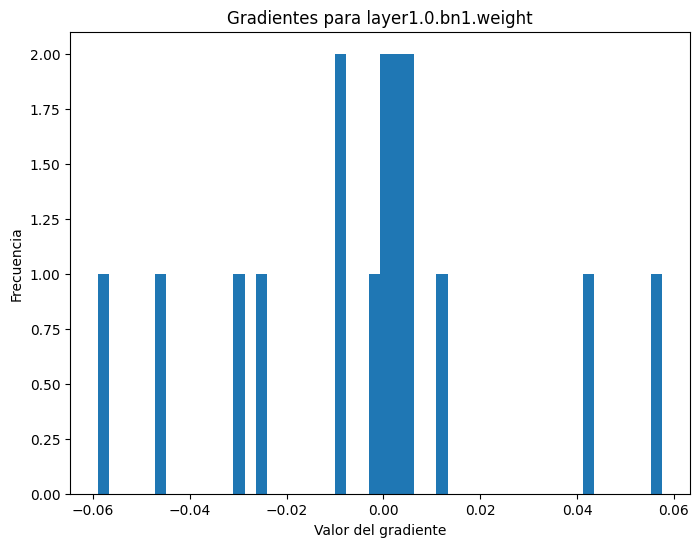

Gradientes para layer1.0.bn1.bias: min=-0.027364585548639297, max=0.015971168875694275, mean=-0.004655992612242699, std=0.01196696050465107


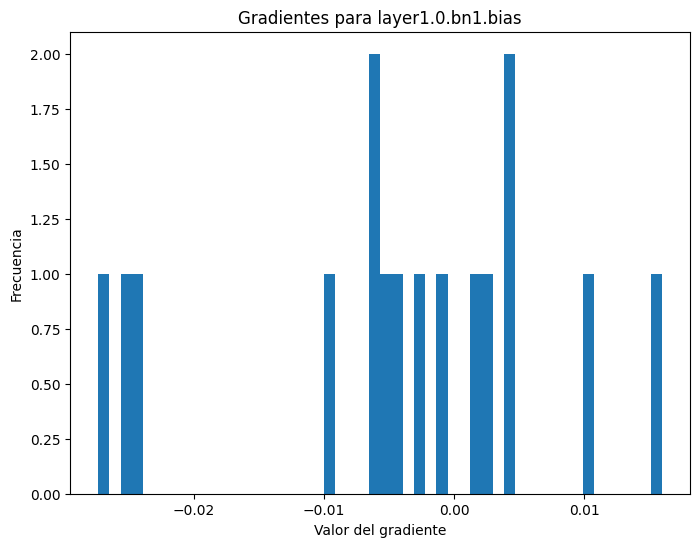

Gradientes para layer2.8.conv1.weight: min=-0.012855214066803455, max=0.009365759789943695, mean=3.1434417451237096e-06, std=0.0011949972249567509


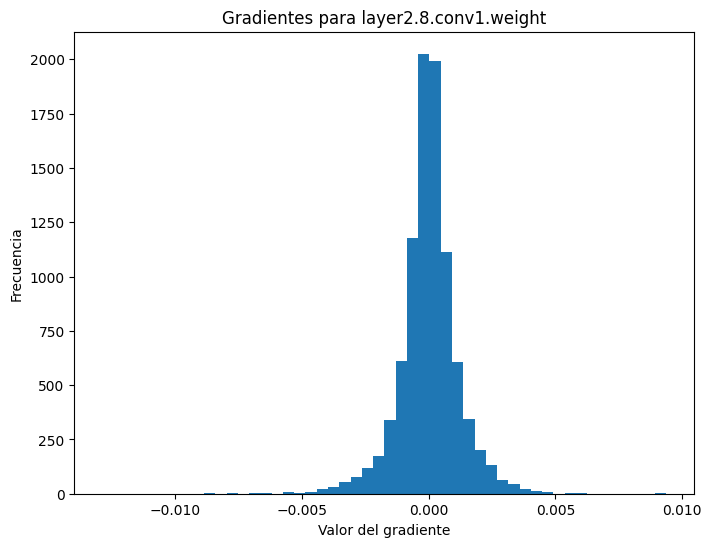

Gradientes para layer2.8.bn1.weight: min=-0.005700245499610901, max=0.0029159041587263346, mean=5.614466135739349e-05, std=0.0015216706087812781


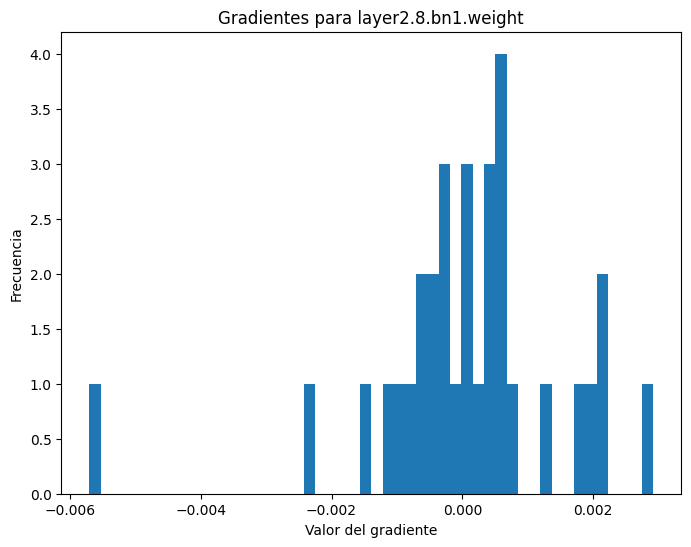

Gradientes para layer2.8.bn1.bias: min=-0.008594654500484467, max=0.008395170792937279, mean=0.000904192915186286, std=0.0031034951098263264


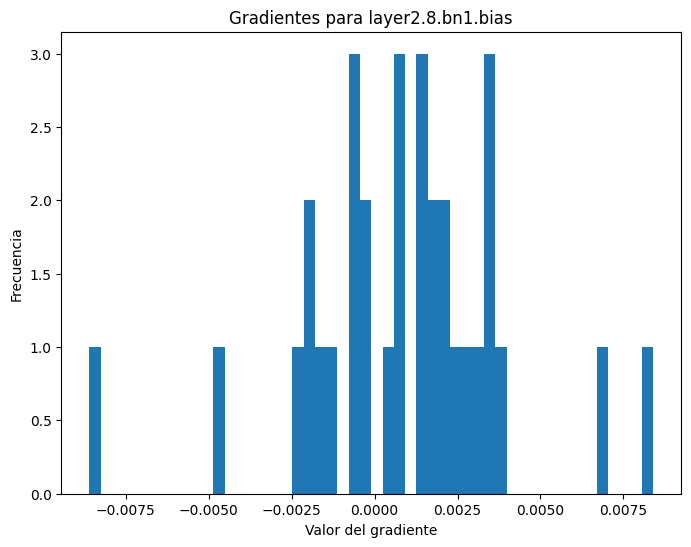

Gradientes para linear.weight: min=-0.11793317645788193, max=0.07114247977733612, mean=1.8626451769865326e-10, std=0.013597763143479824


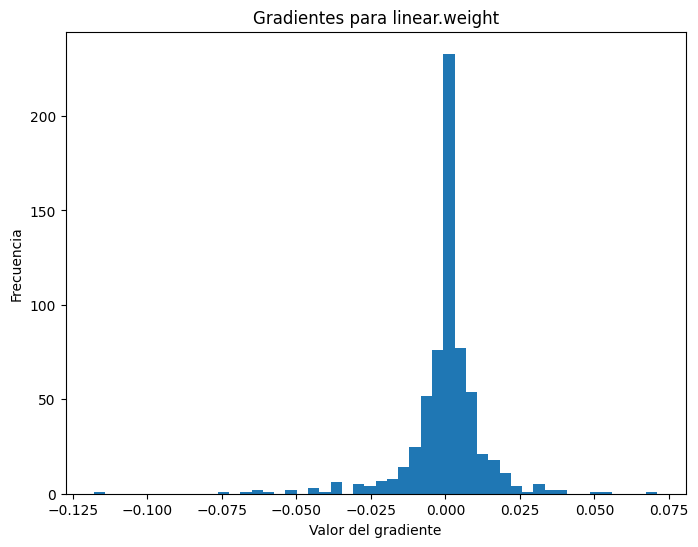

Gradientes para linear.bias: min=-0.05369614437222481, max=0.031166937202215195, mean=7.683411129555395e-10, std=0.022139495238661766


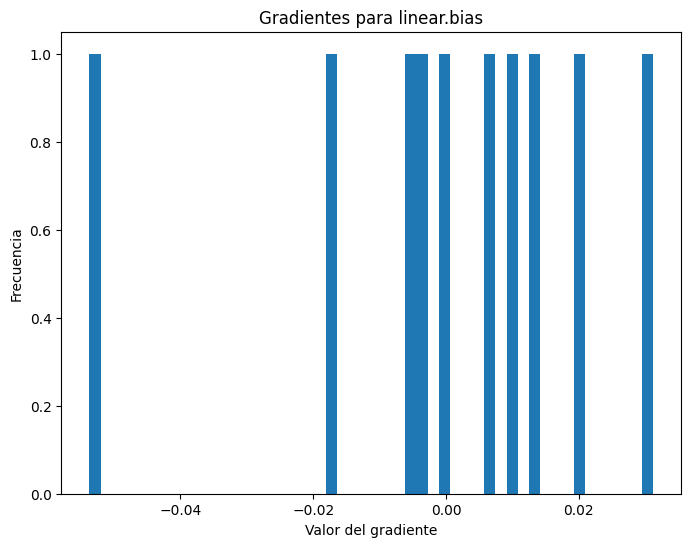

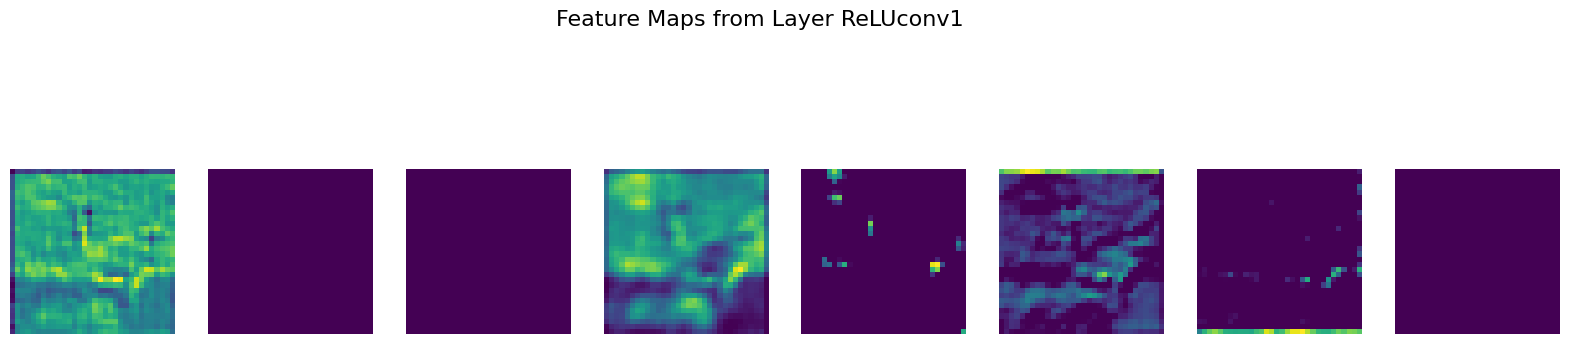

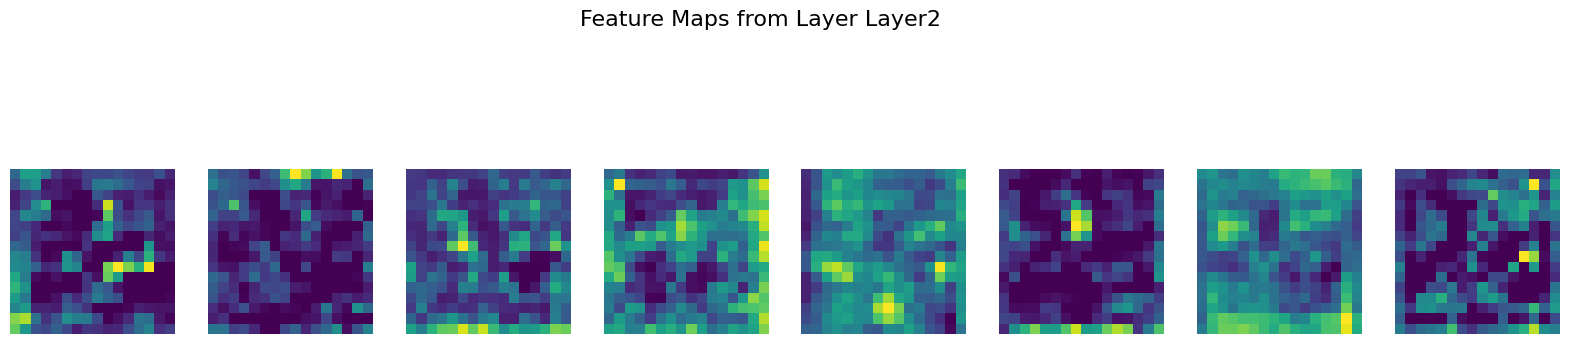

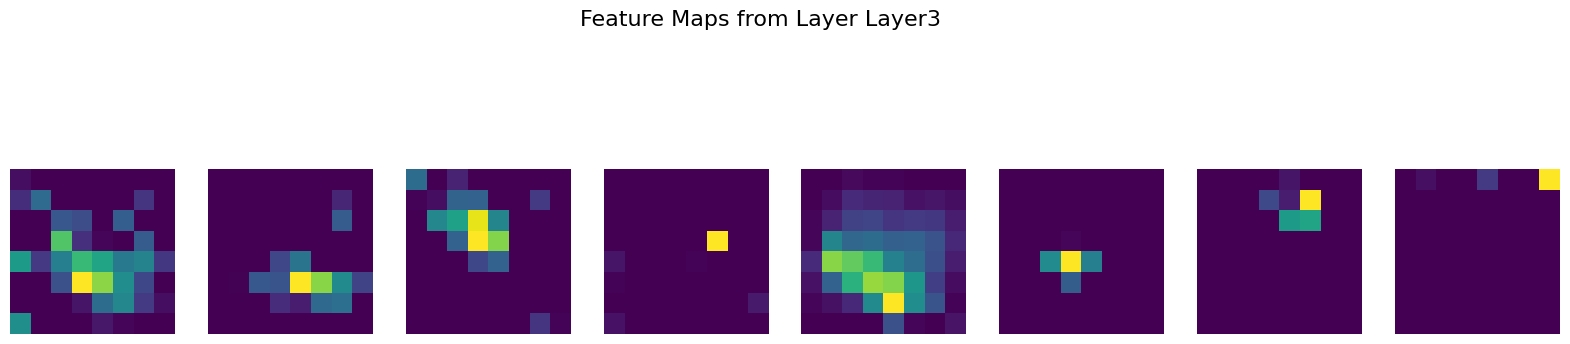

0.04
Epoch 11/70
Iteración 3555 - Lote 35/352 - Pérdida de Entrenamiento: 0.5566, Precisión de Entrenamiento: 0.8054
Iteración 3590 - Lote 70/352 - Pérdida de Entrenamiento: 0.5608, Precisión de Entrenamiento: 0.8058
Iteración 3625 - Lote 105/352 - Pérdida de Entrenamiento: 0.5602, Precisión de Entrenamiento: 0.8052
Iteración 3660 - Lote 140/352 - Pérdida de Entrenamiento: 0.5554, Precisión de Entrenamiento: 0.8069
Iteración 3695 - Lote 175/352 - Pérdida de Entrenamiento: 0.5503, Precisión de Entrenamiento: 0.8094
Iteración 3730 - Lote 210/352 - Pérdida de Entrenamiento: 0.5513, Precisión de Entrenamiento: 0.8097
Iteración 3765 - Lote 245/352 - Pérdida de Entrenamiento: 0.5518, Precisión de Entrenamiento: 0.8098
Iteración 3800 - Lote 280/352 - Pérdida de Entrenamiento: 0.5510, Precisión de Entrenamiento: 0.8097
Iteración 3835 - Lote 315/352 - Pérdida de Entrenamiento: 0.5465, Precisión de Entrenamiento: 0.8108
Iteración 3870 - Lote 350/352 - Pérdida de Entrenamiento: 0.5468, Precisión 

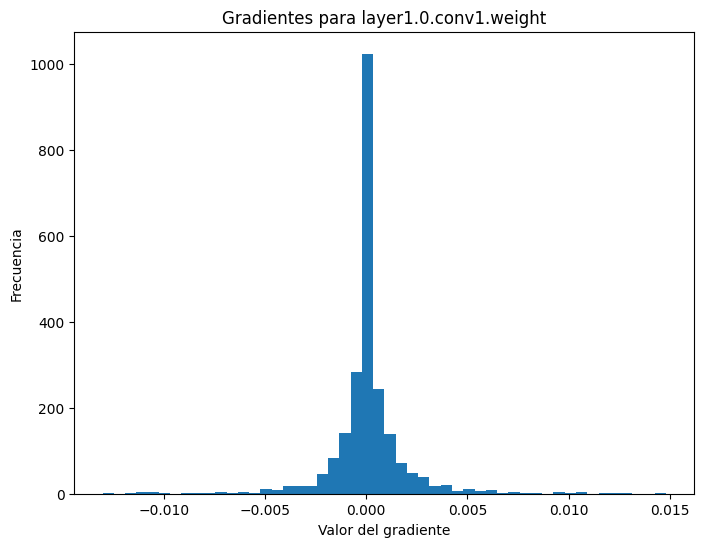

Gradientes para layer1.0.bn1.weight: min=-0.023576980456709862, max=0.008219776675105095, mean=0.0004426384693942964, std=0.007016053423285484


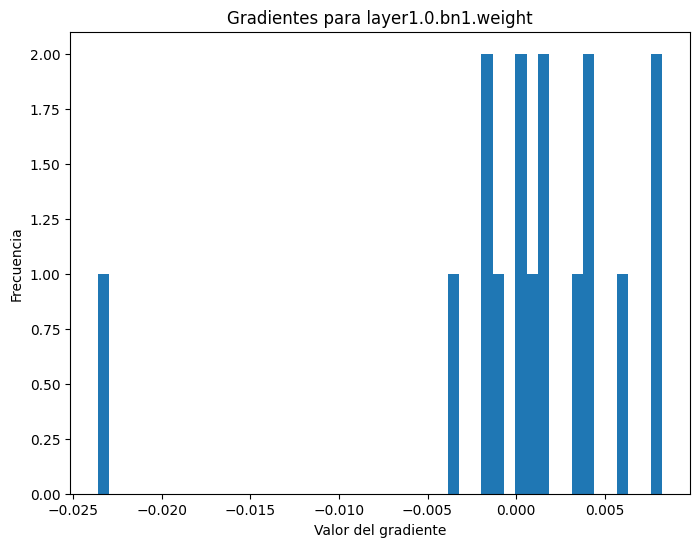

Gradientes para layer1.0.bn1.bias: min=-0.024323362857103348, max=0.009560639038681984, mean=-0.0011741889175027609, std=0.007928233593702316


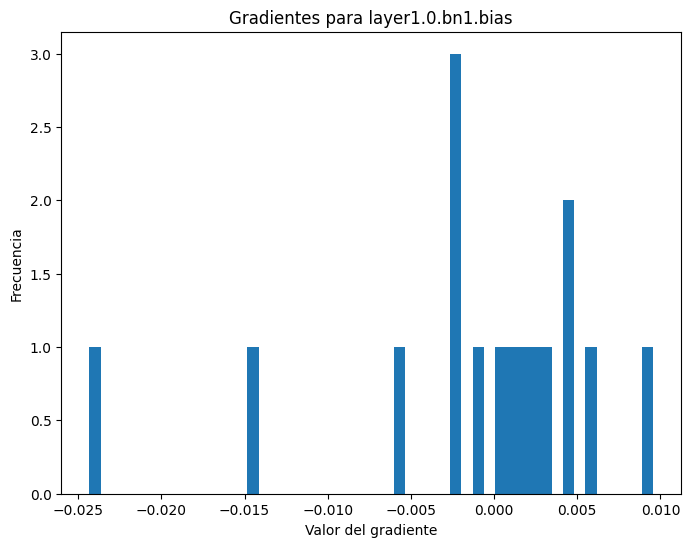

Gradientes para layer2.8.conv1.weight: min=-0.006231227889657021, max=0.005163330119103193, mean=3.407553958822973e-05, std=0.0008445074781775475


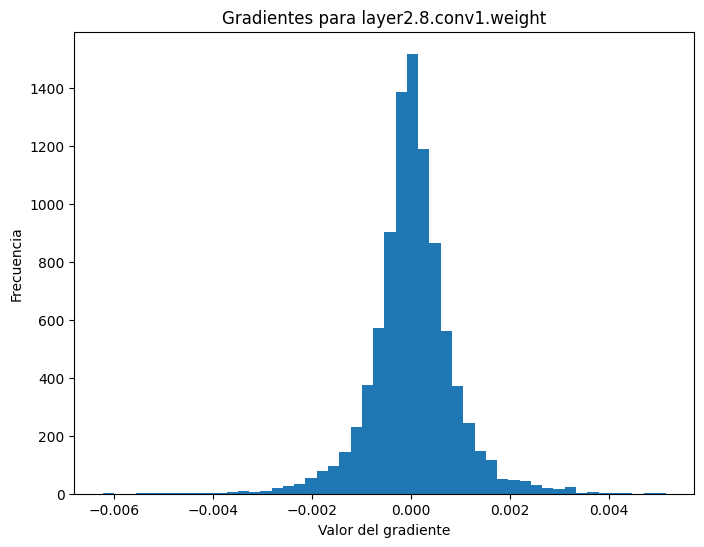

Gradientes para layer2.8.bn1.weight: min=-0.0034604223910719156, max=0.0034103188663721085, mean=1.1021271347999573e-05, std=0.001579945906996727


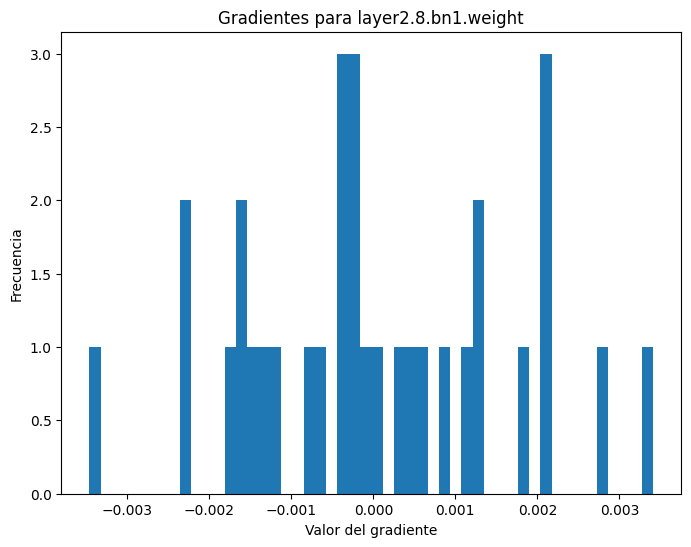

Gradientes para layer2.8.bn1.bias: min=-0.003975671716034412, max=0.004267173819243908, mean=-2.4294989998452365e-05, std=0.0020405289251357317


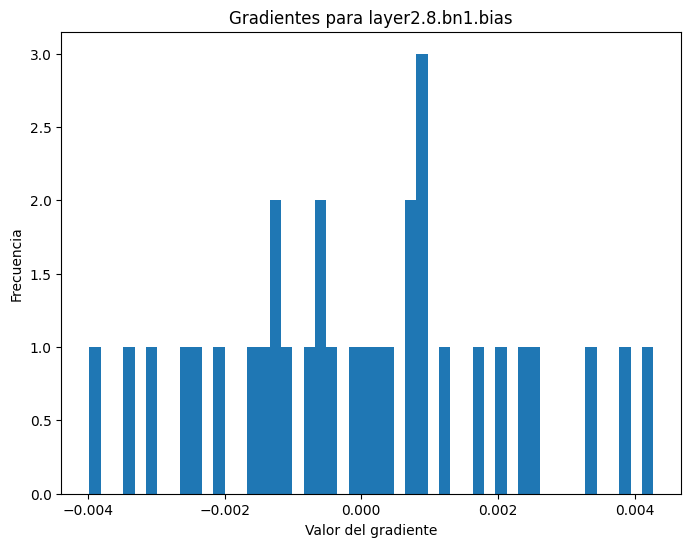

Gradientes para linear.weight: min=-0.055732809007167816, max=0.03048361837863922, mean=1.1641532182693481e-09, std=0.006440968252718449


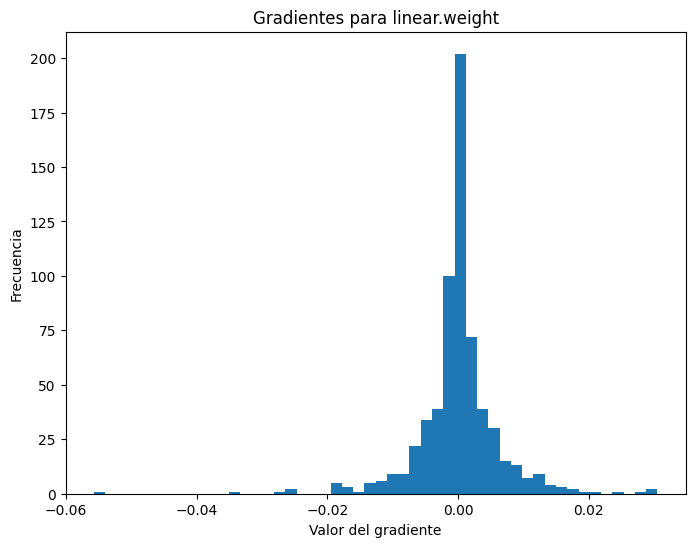

Gradientes para linear.bias: min=-0.02490723878145218, max=0.022830605506896973, mean=2.5727786567841804e-09, std=0.01162443496286869


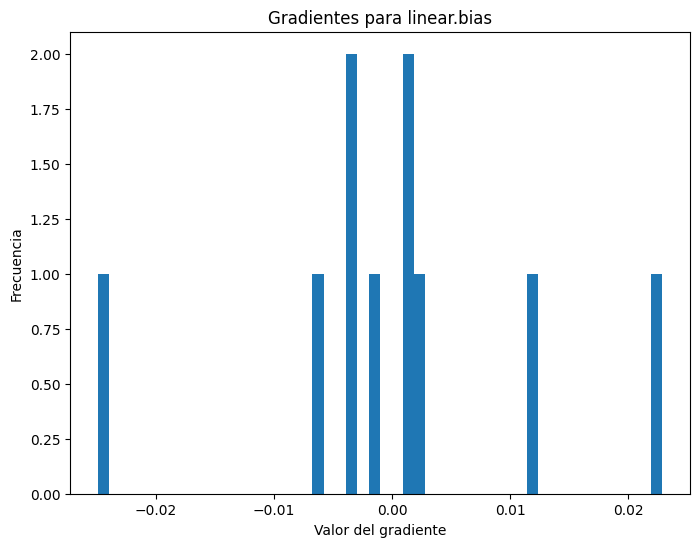

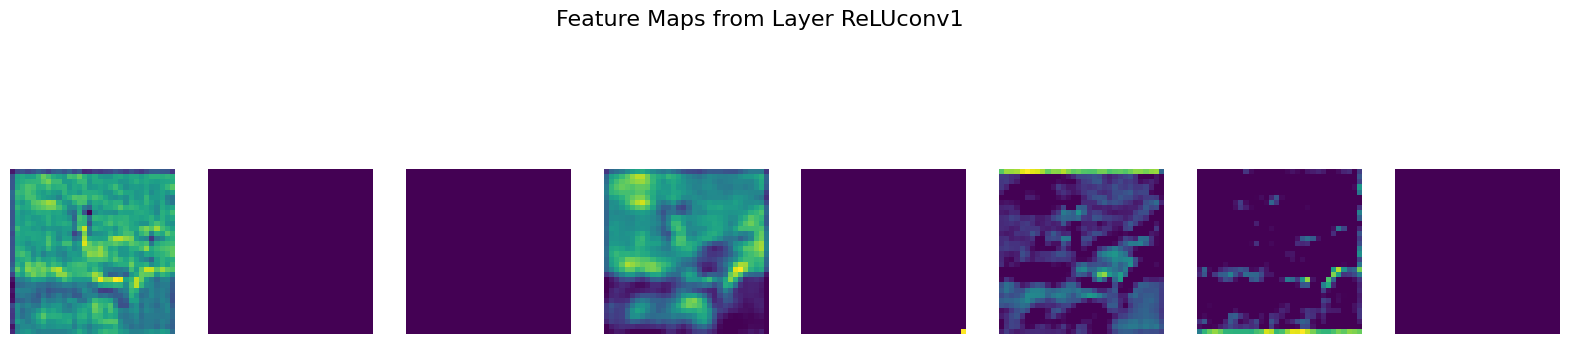

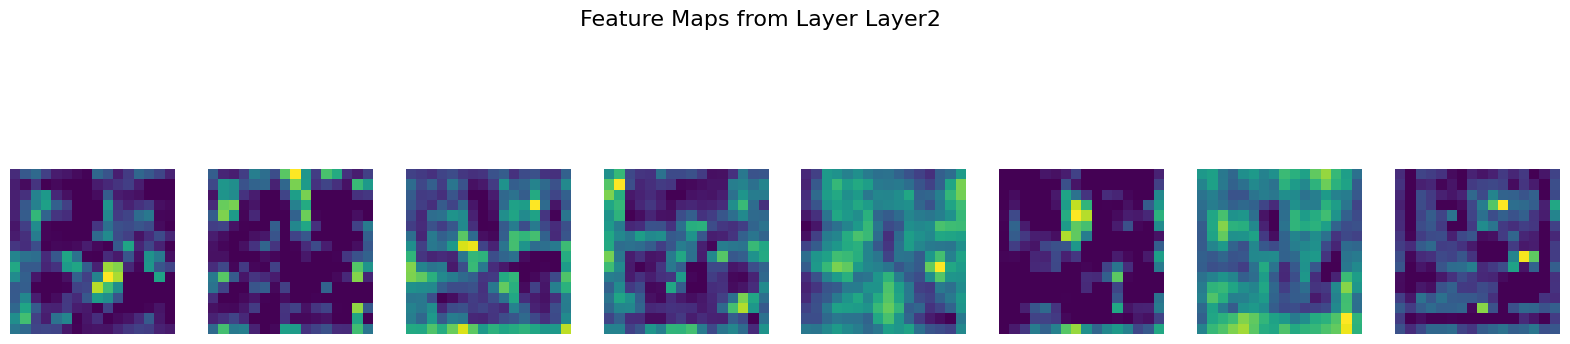

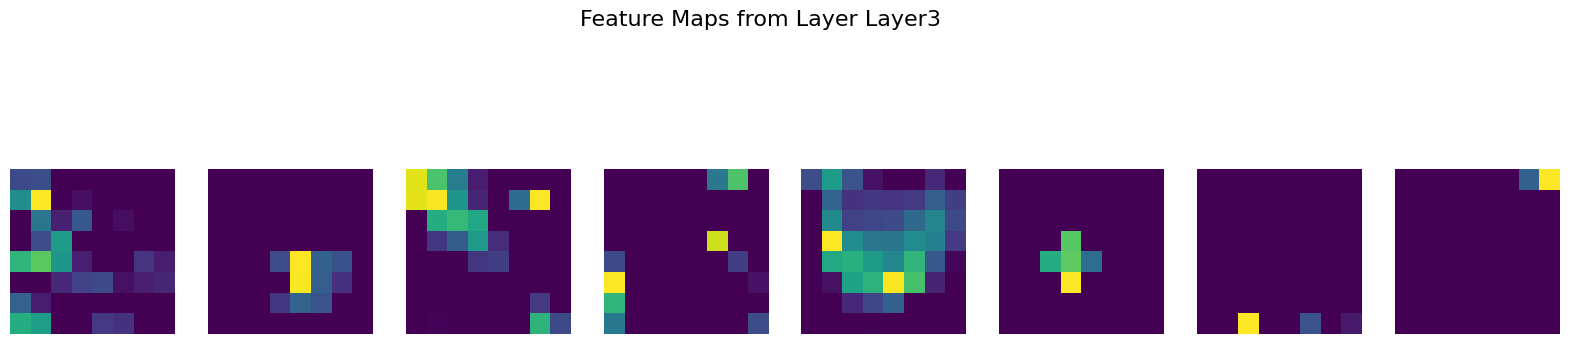

0.04
Epoch 16/70
Iteración 5315 - Lote 35/352 - Pérdida de Entrenamiento: 0.4097, Precisión de Entrenamiento: 0.8531
Iteración 5350 - Lote 70/352 - Pérdida de Entrenamiento: 0.4110, Precisión de Entrenamiento: 0.8542
Iteración 5385 - Lote 105/352 - Pérdida de Entrenamiento: 0.4061, Precisión de Entrenamiento: 0.8577
Iteración 5420 - Lote 140/352 - Pérdida de Entrenamiento: 0.4003, Precisión de Entrenamiento: 0.8592
Iteración 5455 - Lote 175/352 - Pérdida de Entrenamiento: 0.4006, Precisión de Entrenamiento: 0.8592
Iteración 5490 - Lote 210/352 - Pérdida de Entrenamiento: 0.4010, Precisión de Entrenamiento: 0.8602
Iteración 5525 - Lote 245/352 - Pérdida de Entrenamiento: 0.4035, Precisión de Entrenamiento: 0.8590
Iteración 5560 - Lote 280/352 - Pérdida de Entrenamiento: 0.4046, Precisión de Entrenamiento: 0.8590
Iteración 5595 - Lote 315/352 - Pérdida de Entrenamiento: 0.4050, Precisión de Entrenamiento: 0.8592
Iteración 5630 - Lote 350/352 - Pérdida de Entrenamiento: 0.4055, Precisión 

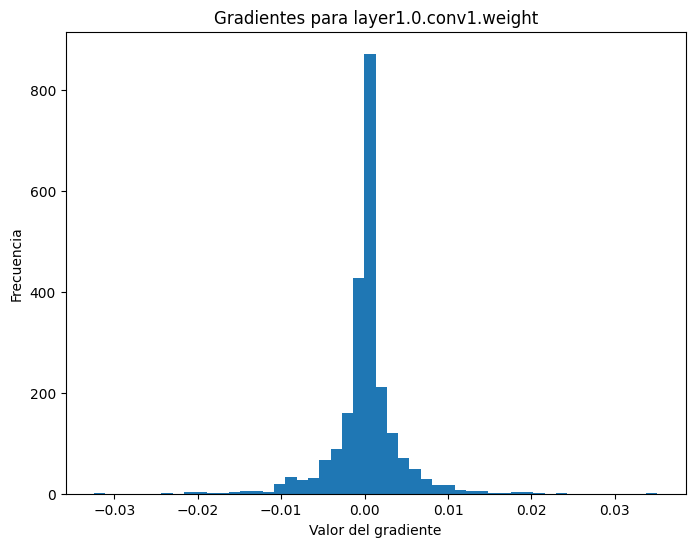

Gradientes para layer1.0.bn1.weight: min=-0.04600027576088905, max=0.025214631110429764, mean=-0.004878932610154152, std=0.02109348401427269


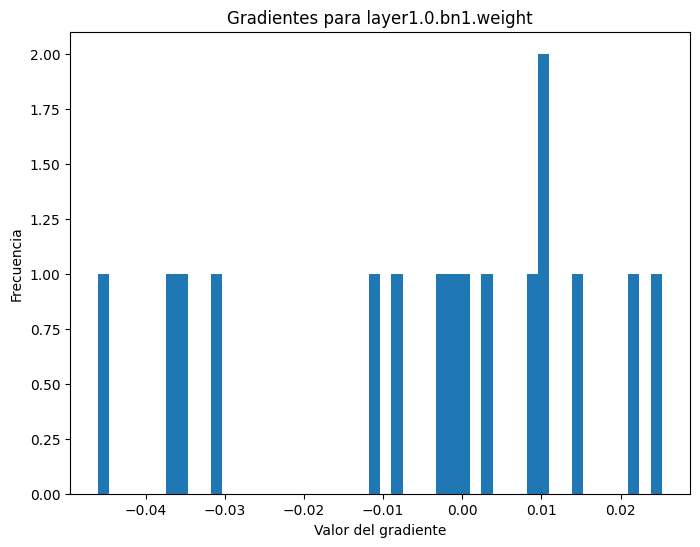

Gradientes para layer1.0.bn1.bias: min=-0.03777854144573212, max=0.025163033977150917, mean=-0.007251308299601078, std=0.0157352015376091


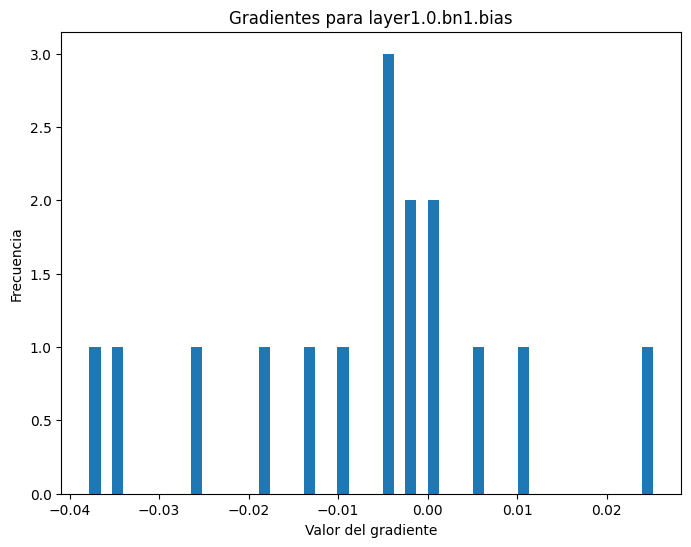

Gradientes para layer2.8.conv1.weight: min=-0.012401080690324306, max=0.01032637245953083, mean=0.00010763642785605043, std=0.001633130363188684


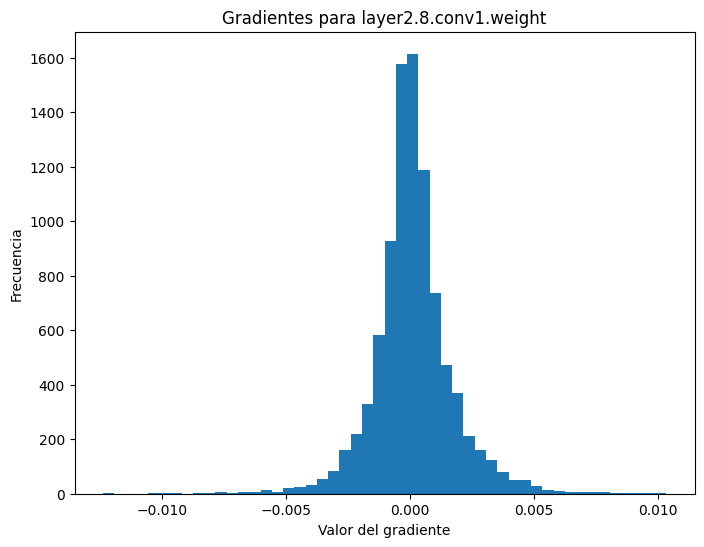

Gradientes para layer2.8.bn1.weight: min=-0.020217973738908768, max=0.0059412578120827675, mean=9.919132571667433e-05, std=0.0045552607625722885


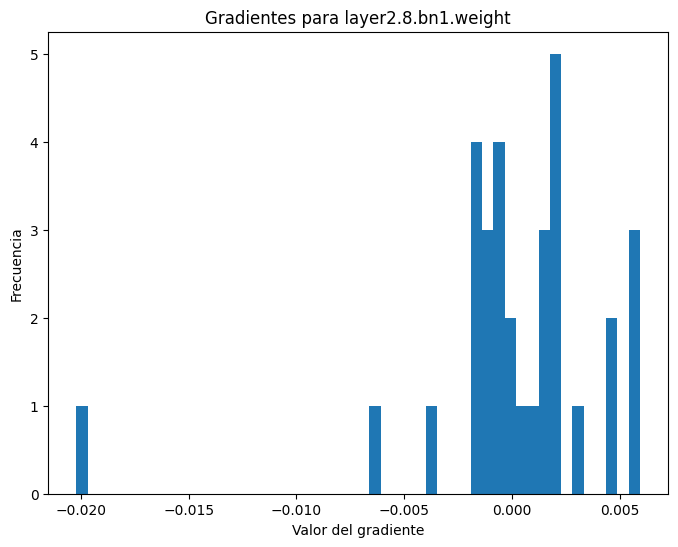

Gradientes para layer2.8.bn1.bias: min=-0.01219468005001545, max=0.007844804786145687, mean=0.0006048153154551983, std=0.004243850242346525


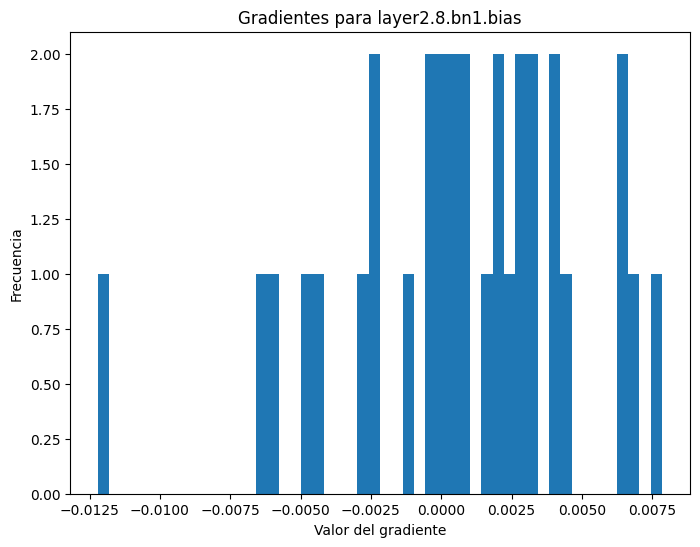

Gradientes para linear.weight: min=-0.04325014352798462, max=0.026913568377494812, mean=4.190951474747351e-10, std=0.007061735726892948


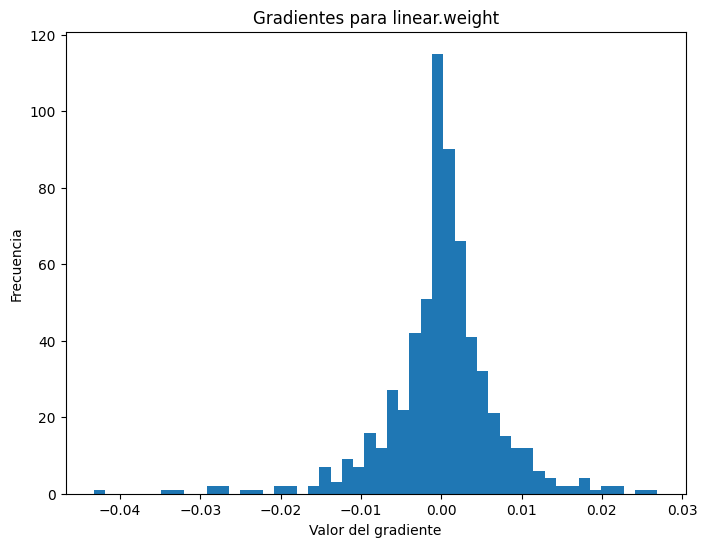

Gradientes para linear.bias: min=-0.02508746087551117, max=0.013763537630438805, mean=7.450580707946131e-10, std=0.010835141874849796


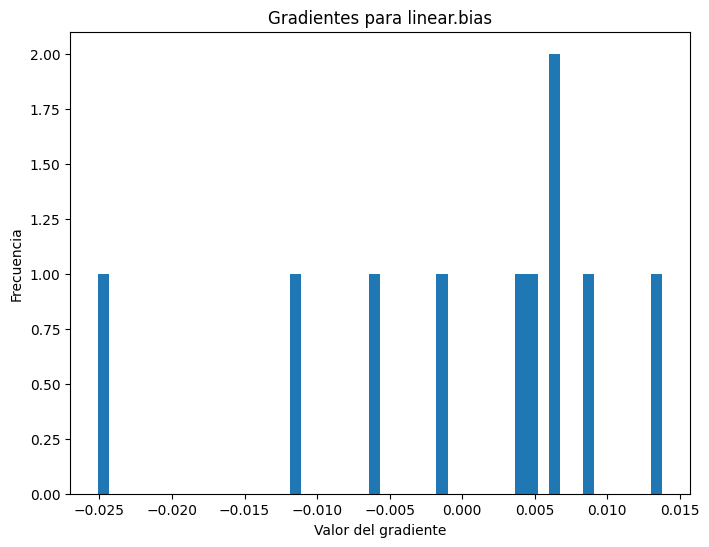

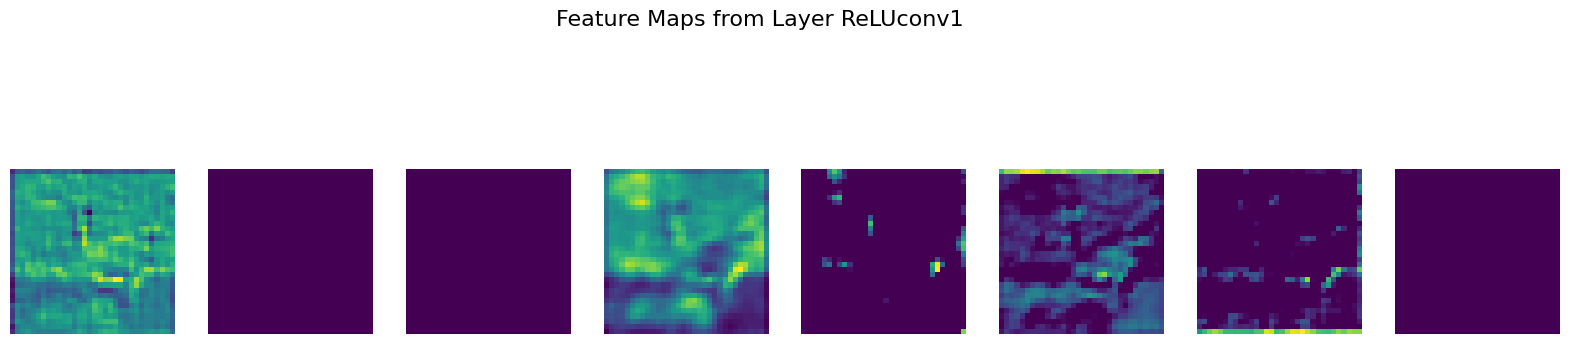

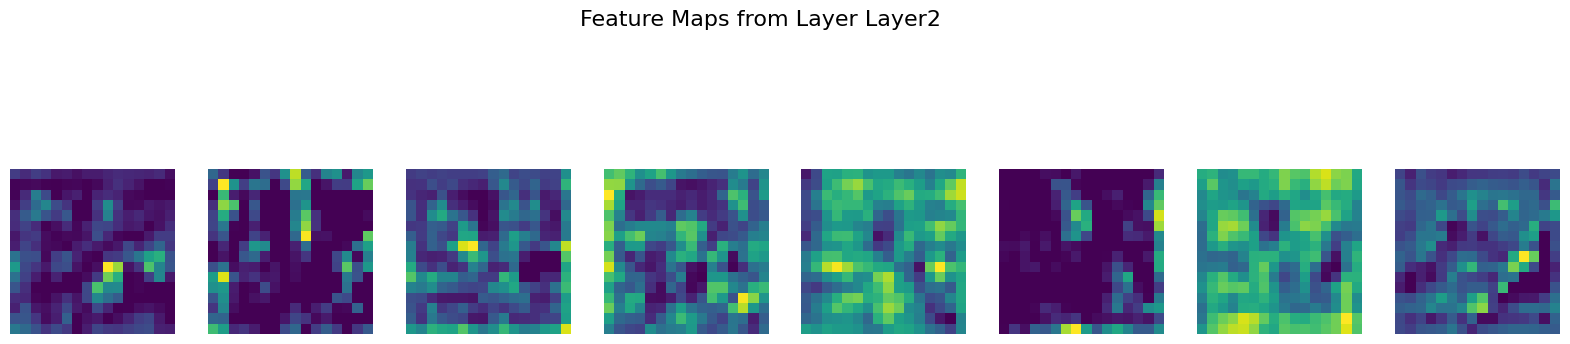

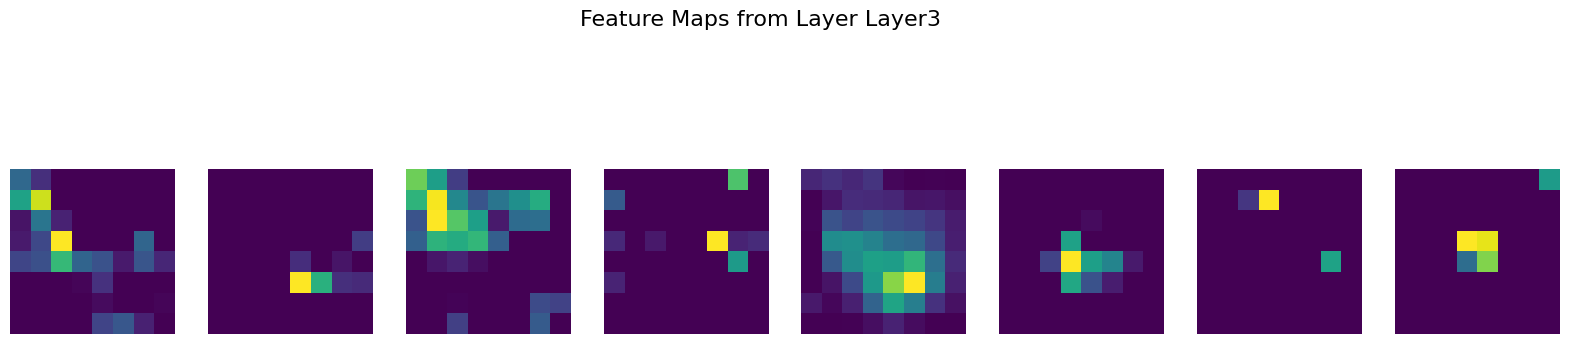

0.04
Epoch 21/70
Iteración 7075 - Lote 35/352 - Pérdida de Entrenamiento: 0.3224, Precisión de Entrenamiento: 0.8904
Iteración 7110 - Lote 70/352 - Pérdida de Entrenamiento: 0.3170, Precisión de Entrenamiento: 0.8912
Iteración 7145 - Lote 105/352 - Pérdida de Entrenamiento: 0.3174, Precisión de Entrenamiento: 0.8904
Iteración 7180 - Lote 140/352 - Pérdida de Entrenamiento: 0.3177, Precisión de Entrenamiento: 0.8901
Iteración 7215 - Lote 175/352 - Pérdida de Entrenamiento: 0.3197, Precisión de Entrenamiento: 0.8888
Iteración 7250 - Lote 210/352 - Pérdida de Entrenamiento: 0.3208, Precisión de Entrenamiento: 0.8882
Iteración 7285 - Lote 245/352 - Pérdida de Entrenamiento: 0.3203, Precisión de Entrenamiento: 0.8892
Iteración 7320 - Lote 280/352 - Pérdida de Entrenamiento: 0.3209, Precisión de Entrenamiento: 0.8896
Iteración 7355 - Lote 315/352 - Pérdida de Entrenamiento: 0.3237, Precisión de Entrenamiento: 0.8883
Iteración 7390 - Lote 350/352 - Pérdida de Entrenamiento: 0.3252, Precisión 

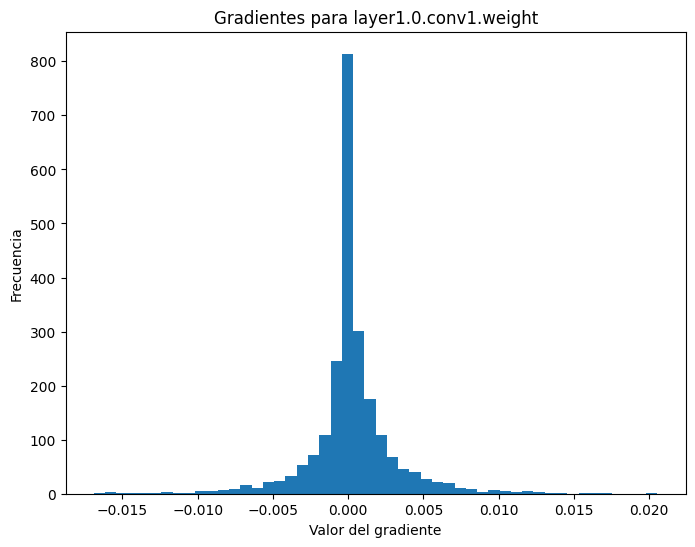

Gradientes para layer1.0.bn1.weight: min=-0.017696257680654526, max=0.03651595488190651, mean=0.0014444268308579922, std=0.013142241165041924


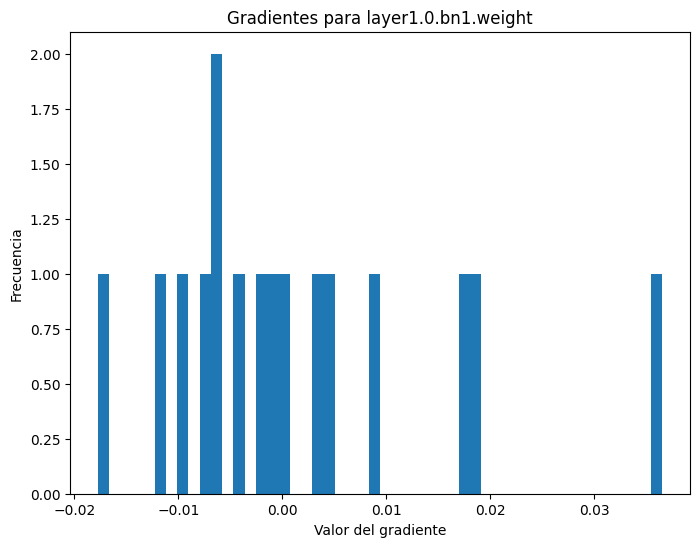

Gradientes para layer1.0.bn1.bias: min=-0.03808749467134476, max=0.01766582950949669, mean=-0.003323934506624937, std=0.01291158702224493


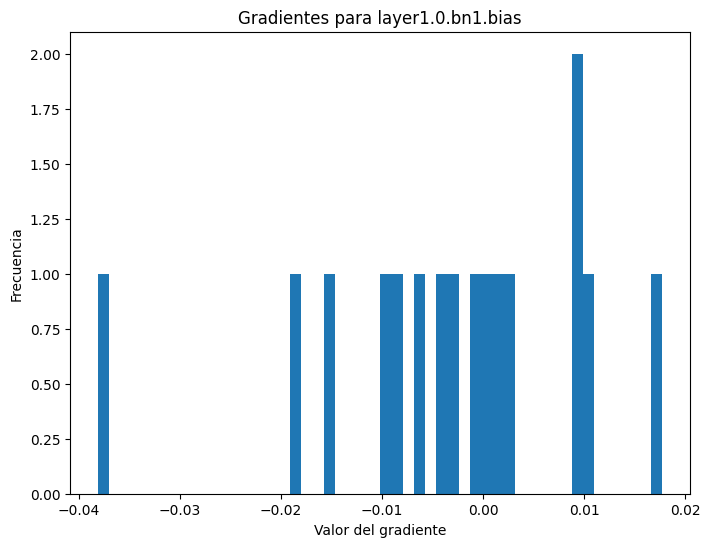

Gradientes para layer2.8.conv1.weight: min=-0.008369210176169872, max=0.009184656664729118, mean=1.6525000319234096e-05, std=0.0015025697648525238


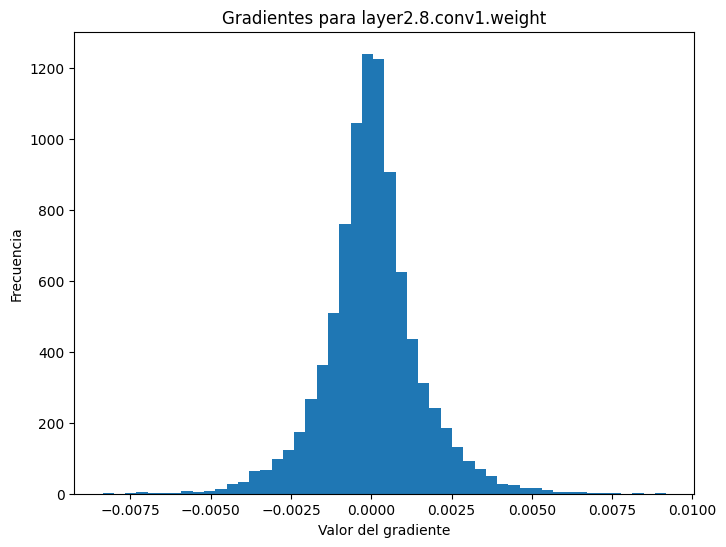

Gradientes para layer2.8.bn1.weight: min=-0.011636354960501194, max=0.007883463986217976, mean=0.00018482358427718282, std=0.003362284740433097


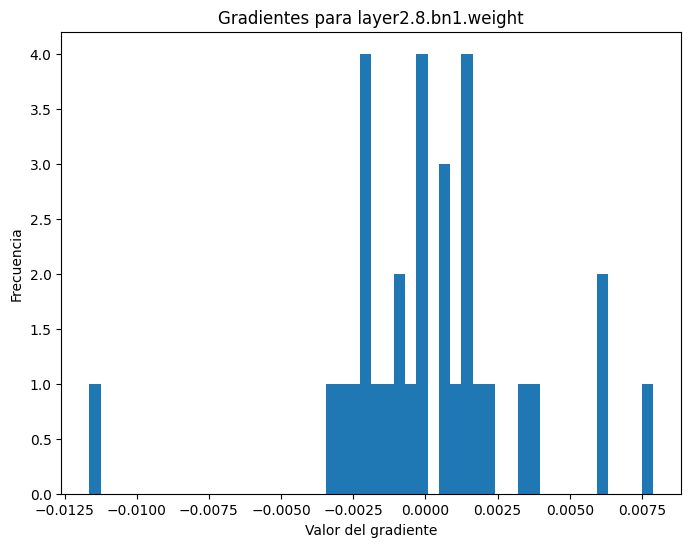

Gradientes para layer2.8.bn1.bias: min=-0.015963353216648102, max=0.009736967273056507, mean=0.0010893886210396886, std=0.004552554339170456


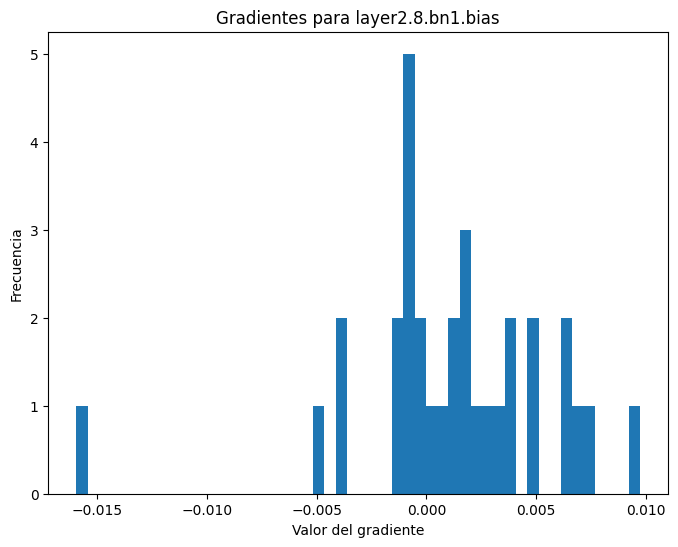

Gradientes para linear.weight: min=-0.10778084397315979, max=0.08502274006605148, mean=1.1175871339474952e-09, std=0.01705164462327957


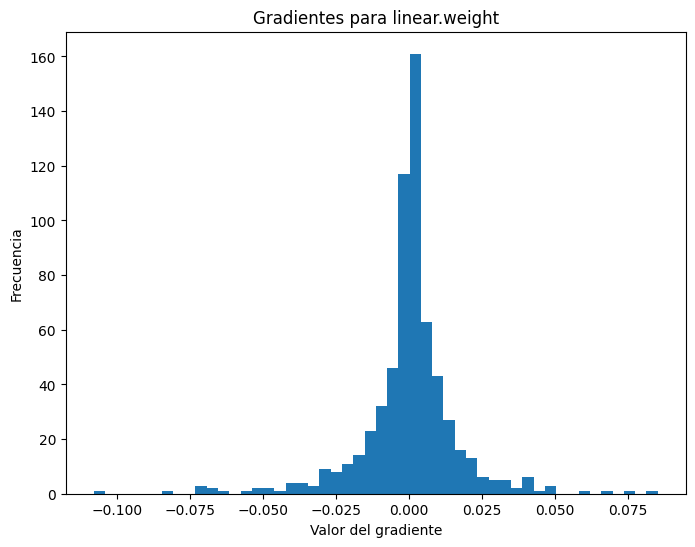

Gradientes para linear.bias: min=-0.058307453989982605, max=0.04834920912981033, mean=2.607703164514419e-09, std=0.027328602969646454


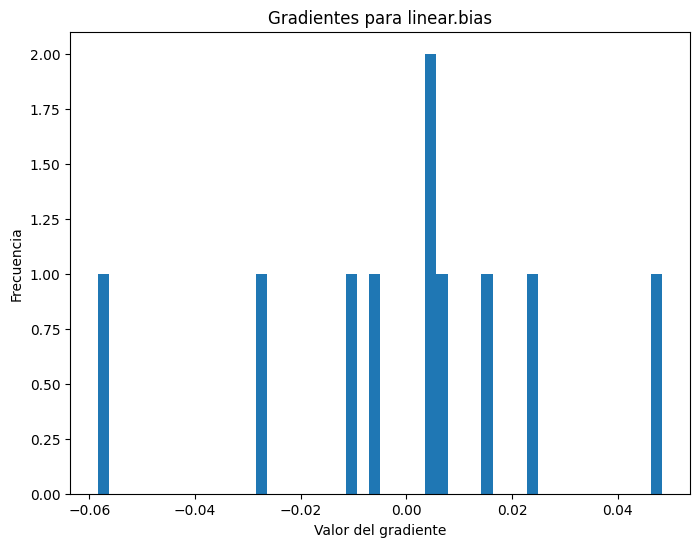

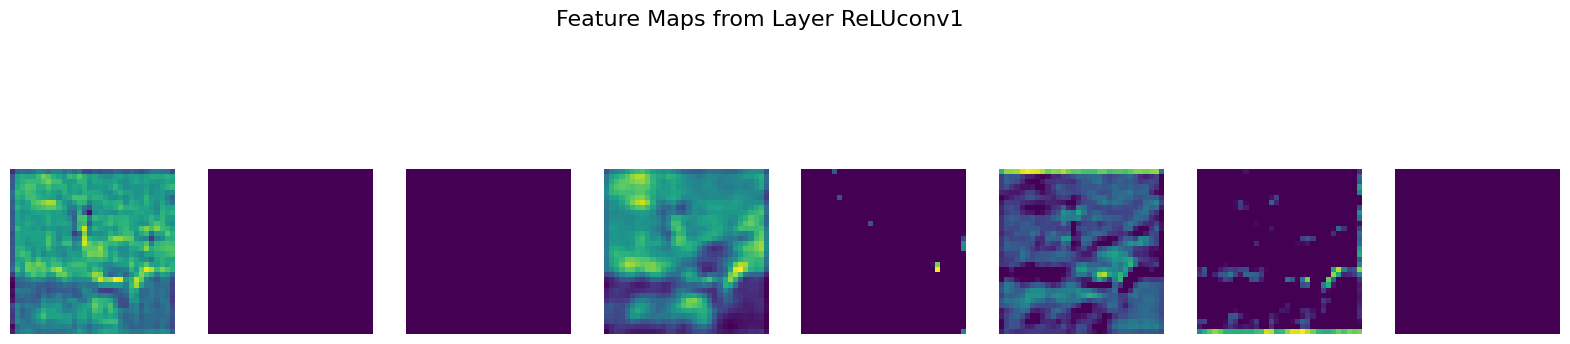

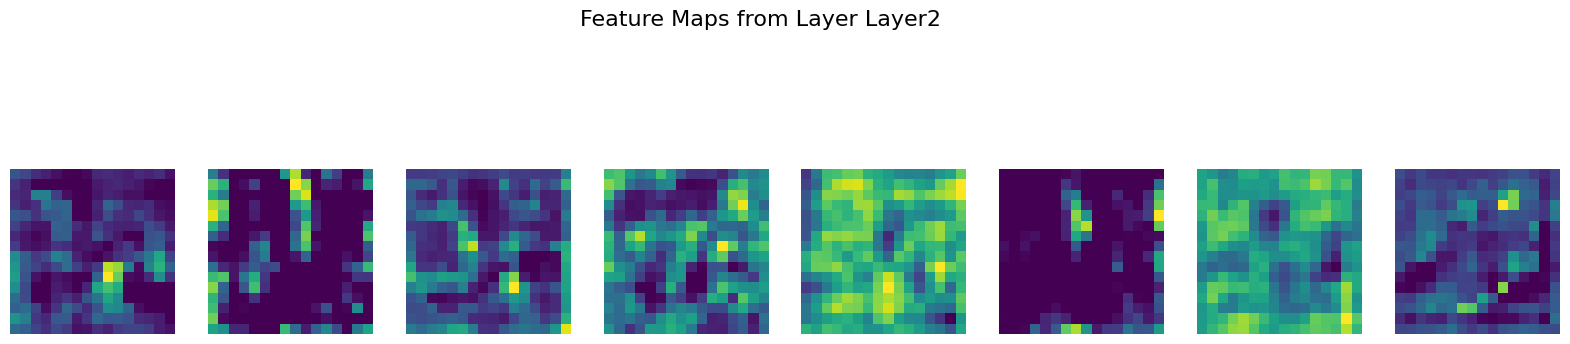

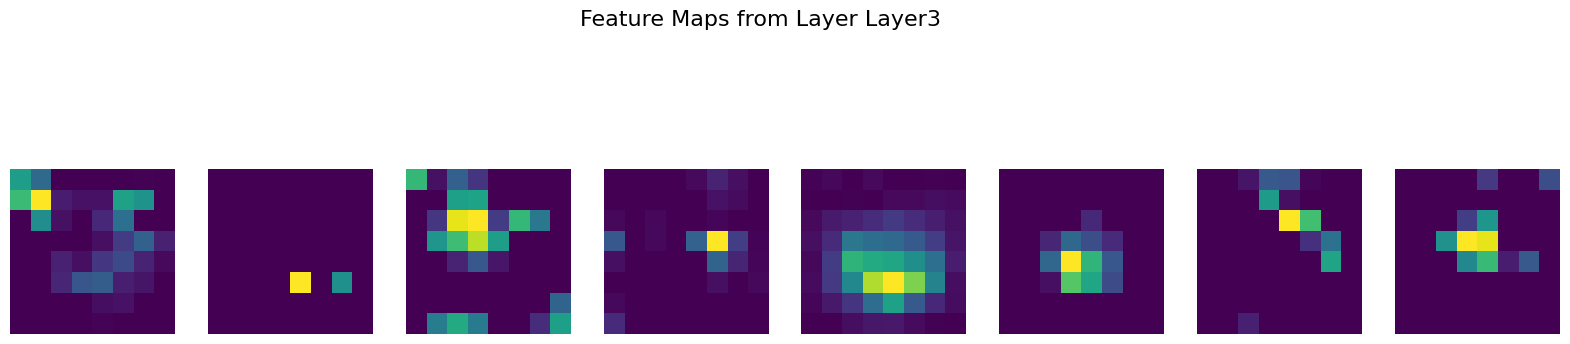

0.004
Epoch 26/70
Iteración 8835 - Lote 35/352 - Pérdida de Entrenamiento: 0.2384, Precisión de Entrenamiento: 0.9192
Iteración 8870 - Lote 70/352 - Pérdida de Entrenamiento: 0.2304, Precisión de Entrenamiento: 0.9206
Iteración 8905 - Lote 105/352 - Pérdida de Entrenamiento: 0.2173, Precisión de Entrenamiento: 0.9251
Iteración 8940 - Lote 140/352 - Pérdida de Entrenamiento: 0.2088, Precisión de Entrenamiento: 0.9285
Iteración 8975 - Lote 175/352 - Pérdida de Entrenamiento: 0.2046, Precisión de Entrenamiento: 0.9302
Iteración 9010 - Lote 210/352 - Pérdida de Entrenamiento: 0.2020, Precisión de Entrenamiento: 0.9313
Iteración 9045 - Lote 245/352 - Pérdida de Entrenamiento: 0.2001, Precisión de Entrenamiento: 0.9322
Iteración 9080 - Lote 280/352 - Pérdida de Entrenamiento: 0.1975, Precisión de Entrenamiento: 0.9333
Iteración 9115 - Lote 315/352 - Pérdida de Entrenamiento: 0.1960, Precisión de Entrenamiento: 0.9340
Iteración 9150 - Lote 350/352 - Pérdida de Entrenamiento: 0.1928, Precisión

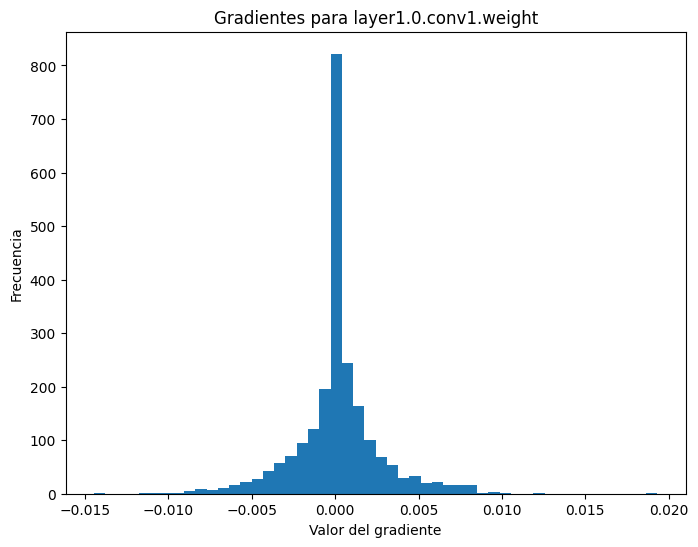

Gradientes para layer1.0.bn1.weight: min=-0.02072588913142681, max=0.02541184052824974, mean=0.0014202720485627651, std=0.011900090612471104


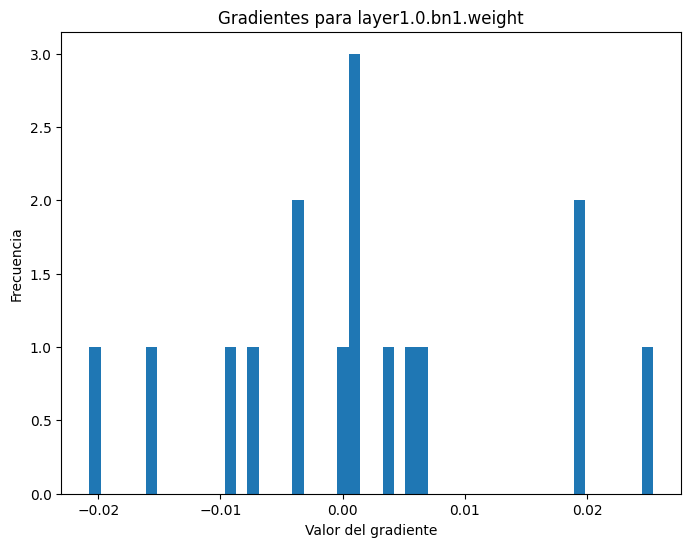

Gradientes para layer1.0.bn1.bias: min=-0.018041932955384254, max=0.013201276771724224, mean=-0.002423571888357401, std=0.00822264701128006


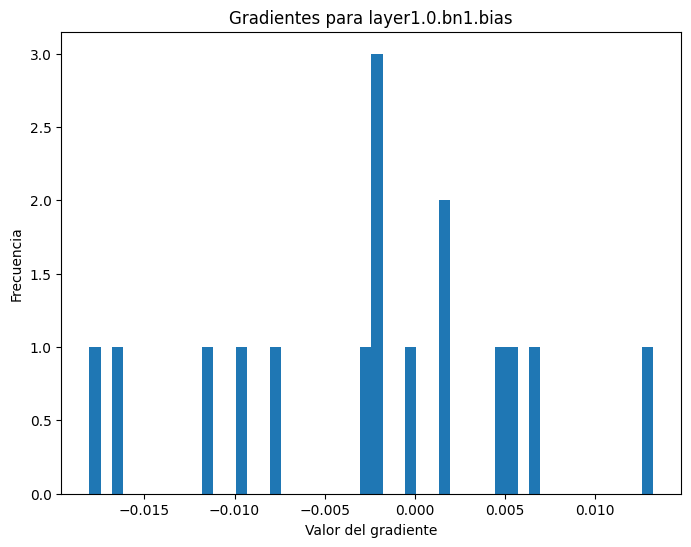

Gradientes para layer2.8.conv1.weight: min=-0.013924422673881054, max=0.01286621205508709, mean=-2.2327822080114856e-05, std=0.0014351614518091083


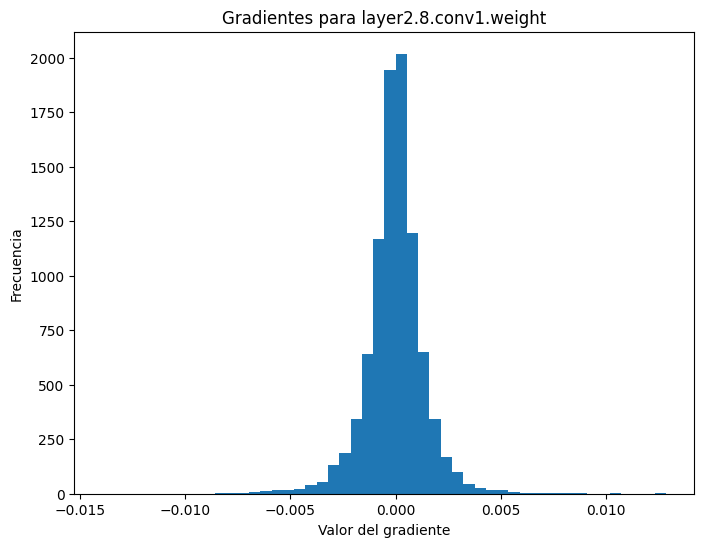

Gradientes para layer2.8.bn1.weight: min=-0.0075144399888813496, max=0.011338656768202782, mean=2.830862649716437e-05, std=0.003866073675453663


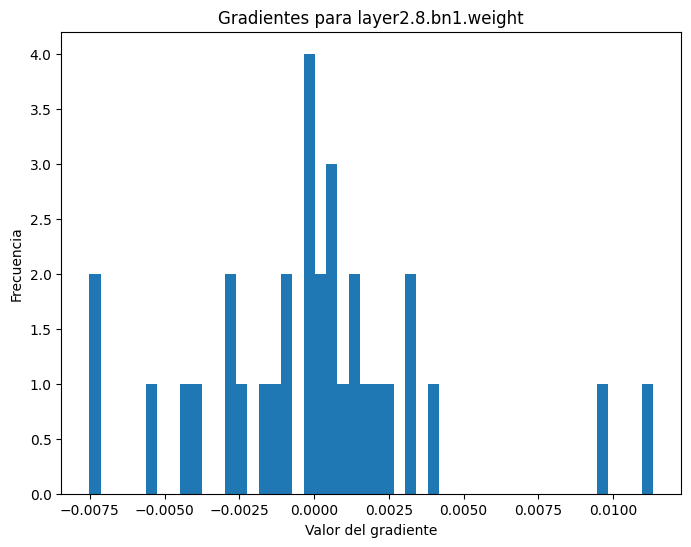

Gradientes para layer2.8.bn1.bias: min=-0.010855225846171379, max=0.012832137756049633, mean=0.0002951443602796644, std=0.004527564160525799


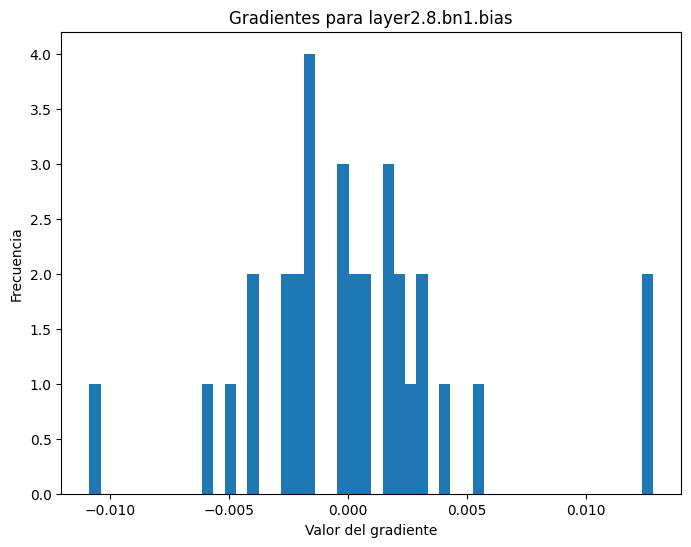

Gradientes para linear.weight: min=-0.0860714390873909, max=0.0489024743437767, mean=1.8626451769865326e-10, std=0.00968859251588583


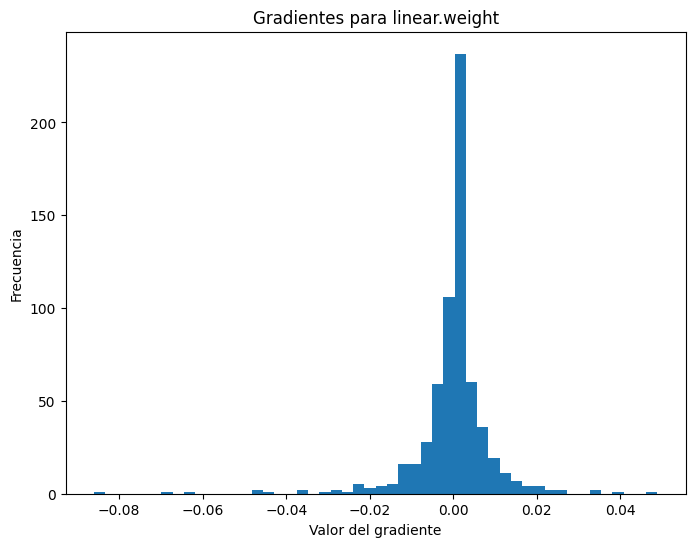

Gradientes para linear.bias: min=-0.03159625455737114, max=0.01574530638754368, mean=2.0954757373736754e-10, std=0.012776575982570648


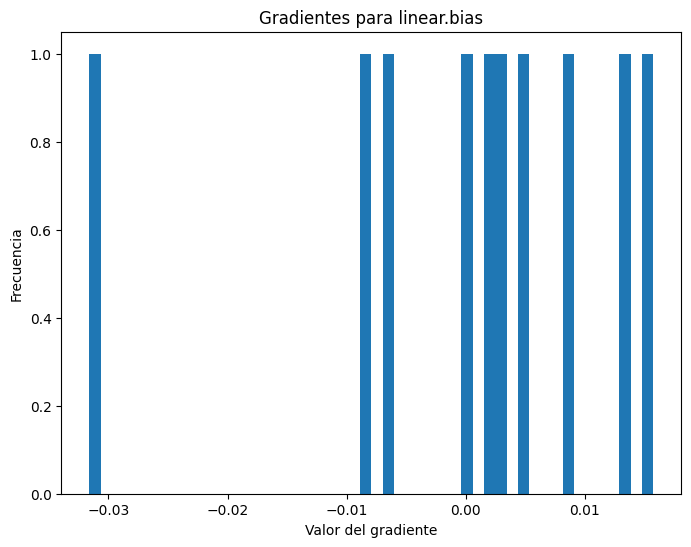

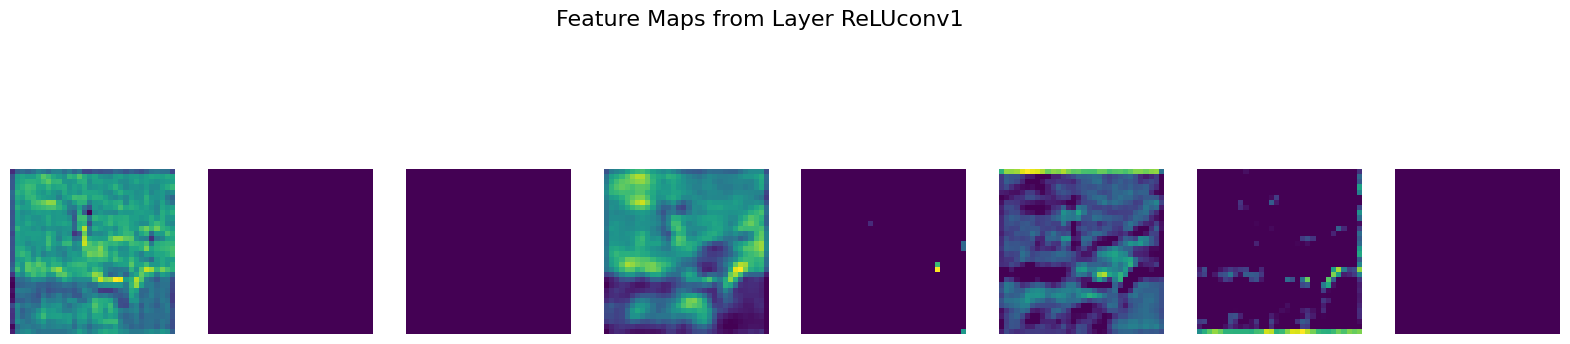

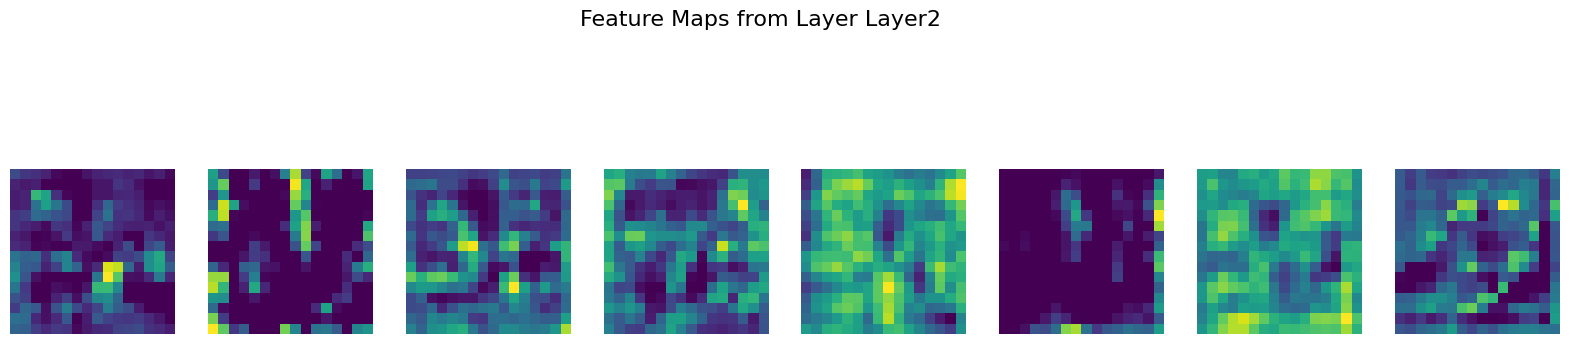

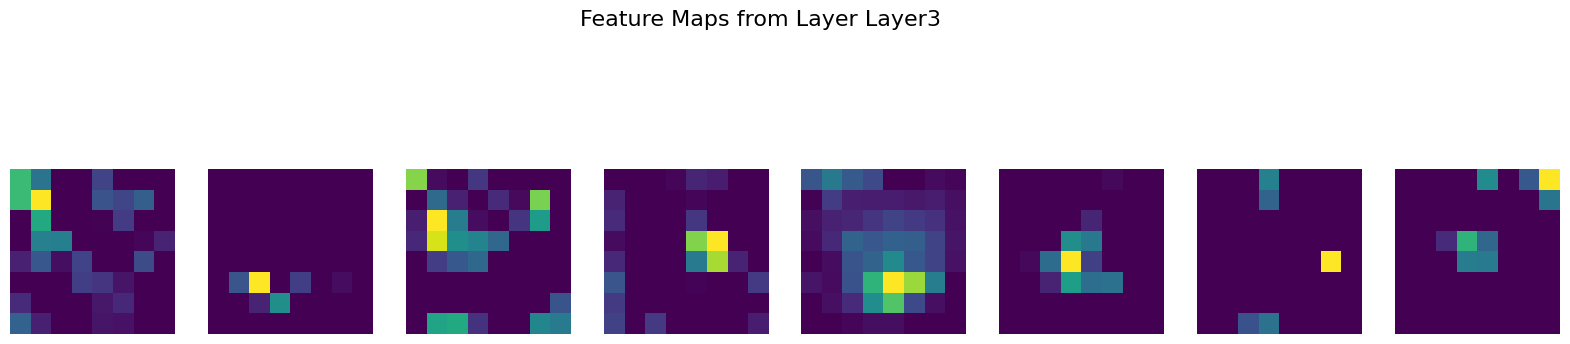

0.004
Epoch 31/70
Iteración 10595 - Lote 35/352 - Pérdida de Entrenamiento: 0.1339, Precisión de Entrenamiento: 0.9574
Iteración 10630 - Lote 70/352 - Pérdida de Entrenamiento: 0.1272, Precisión de Entrenamiento: 0.9580
Iteración 10665 - Lote 105/352 - Pérdida de Entrenamiento: 0.1257, Precisión de Entrenamiento: 0.9582
Iteración 10700 - Lote 140/352 - Pérdida de Entrenamiento: 0.1252, Precisión de Entrenamiento: 0.9580
Iteración 10735 - Lote 175/352 - Pérdida de Entrenamiento: 0.1273, Precisión de Entrenamiento: 0.9574
Iteración 10770 - Lote 210/352 - Pérdida de Entrenamiento: 0.1261, Precisión de Entrenamiento: 0.9575
Iteración 10805 - Lote 245/352 - Pérdida de Entrenamiento: 0.1264, Precisión de Entrenamiento: 0.9570
Iteración 10840 - Lote 280/352 - Pérdida de Entrenamiento: 0.1277, Precisión de Entrenamiento: 0.9568
Iteración 10875 - Lote 315/352 - Pérdida de Entrenamiento: 0.1292, Precisión de Entrenamiento: 0.9564
Iteración 10910 - Lote 350/352 - Pérdida de Entrenamiento: 0.1299,

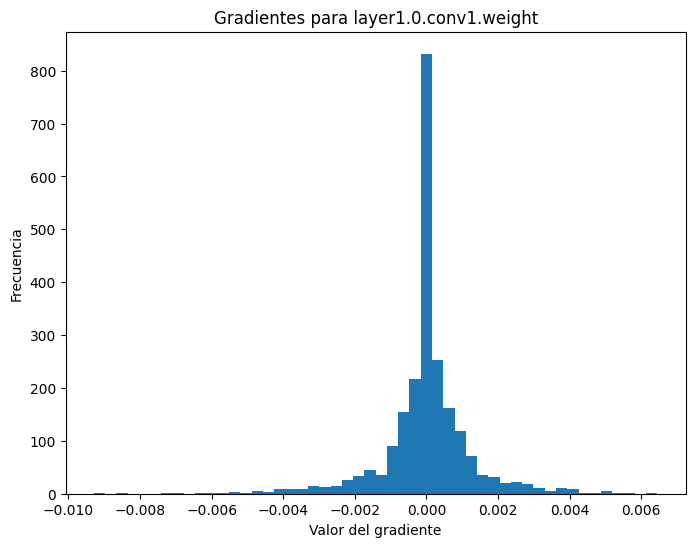

Gradientes para layer1.0.bn1.weight: min=-0.012506669387221336, max=0.015856483951210976, mean=0.0012144377687945962, std=0.0068316045217216015


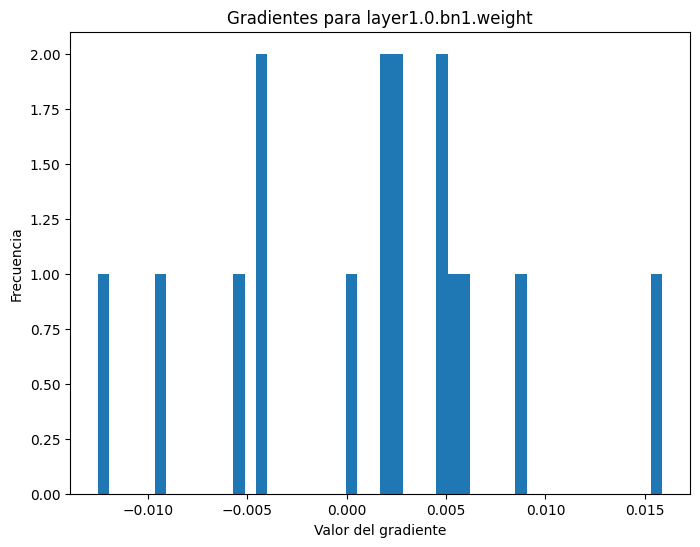

Gradientes para layer1.0.bn1.bias: min=-0.011076211929321289, max=0.008514870889484882, mean=-0.000977431540377438, std=0.005095150787383318


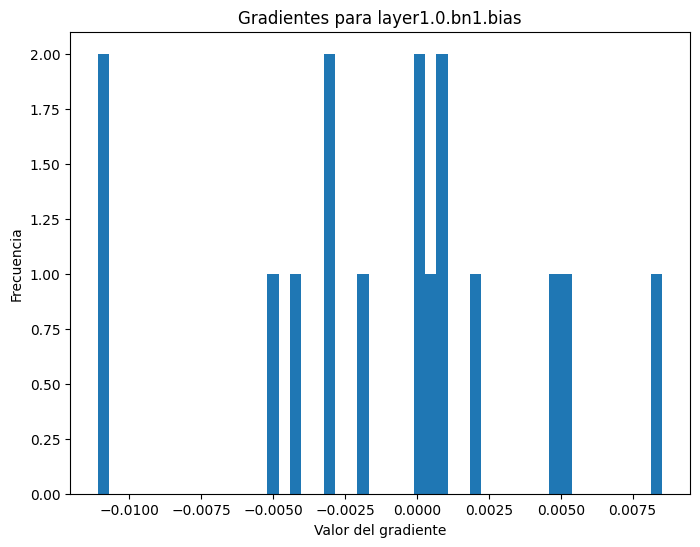

Gradientes para layer2.8.conv1.weight: min=-0.003534571034833789, max=0.004811307415366173, mean=1.9573270037653856e-05, std=0.0006657138583250344


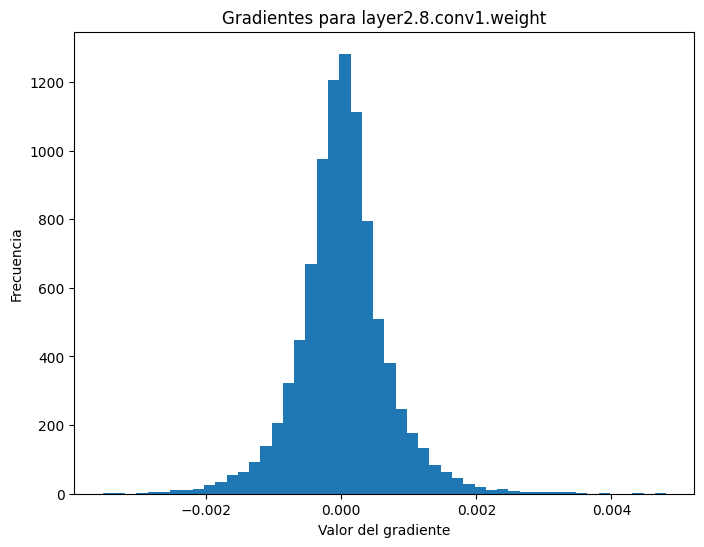

Gradientes para layer2.8.bn1.weight: min=-0.00300373206846416, max=0.003182734129950404, mean=1.5996789443306625e-05, std=0.0014538704417645931


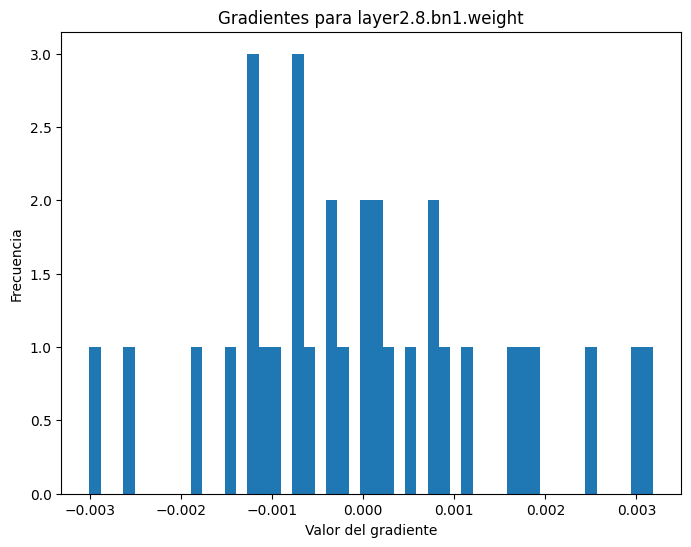

Gradientes para layer2.8.bn1.bias: min=-0.0029112068004906178, max=0.003953374456614256, mean=0.00019868613162543625, std=0.0016568093560636044


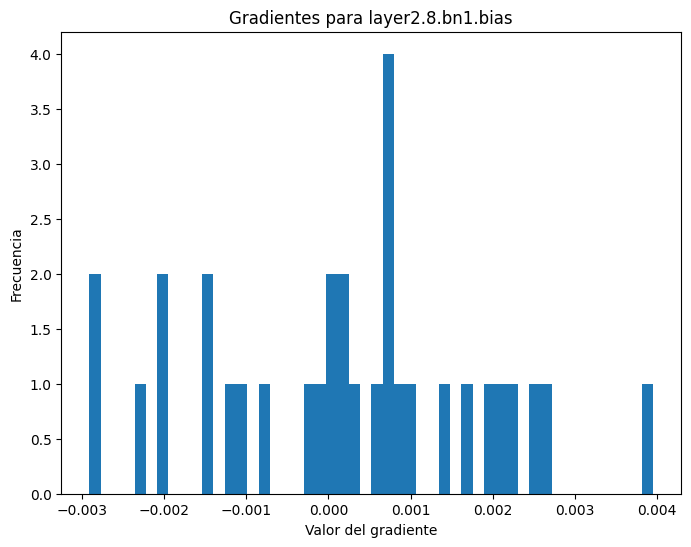

Gradientes para linear.weight: min=-0.02663295716047287, max=0.021547749638557434, mean=6.868504098811457e-10, std=0.0041225384920835495


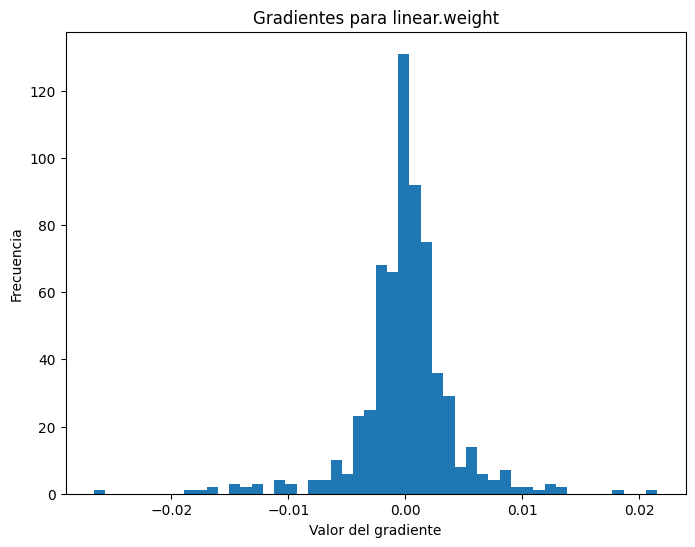

Gradientes para linear.bias: min=-0.0104439752176404, max=0.009338019415736198, mean=8.847564347824743e-10, std=0.005963642615824938


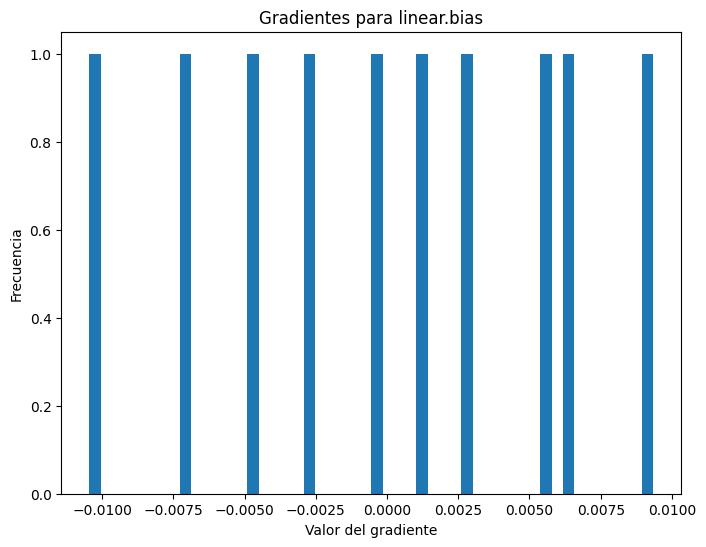

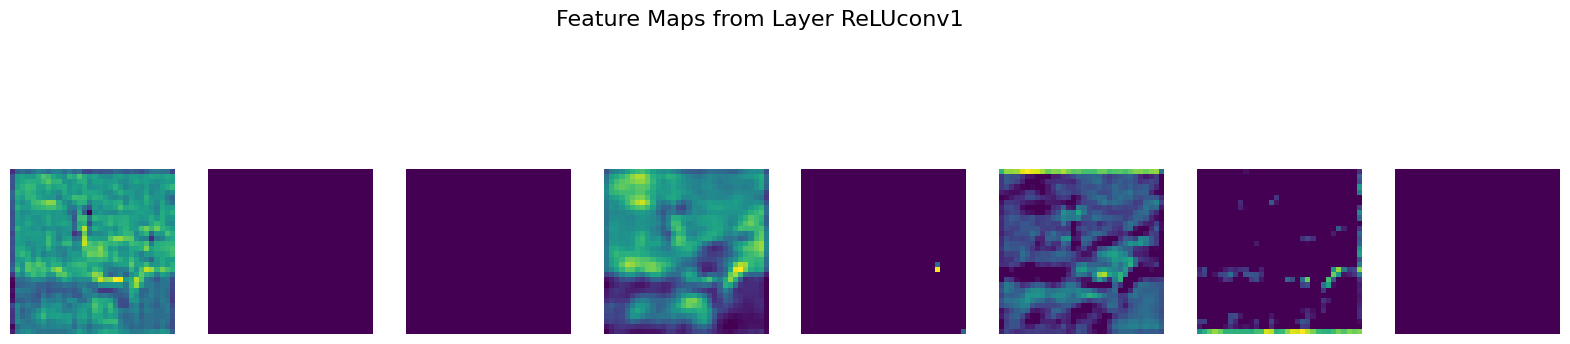

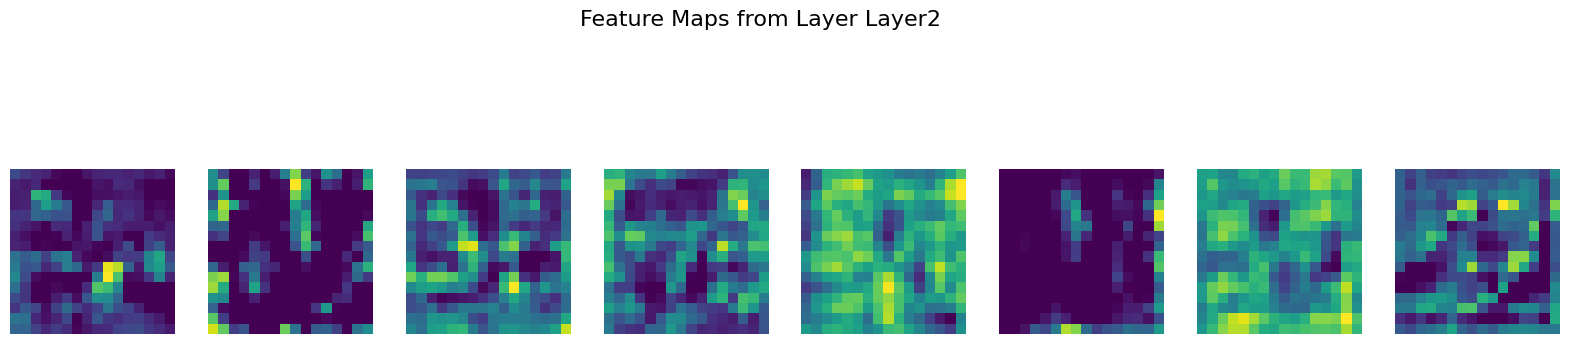

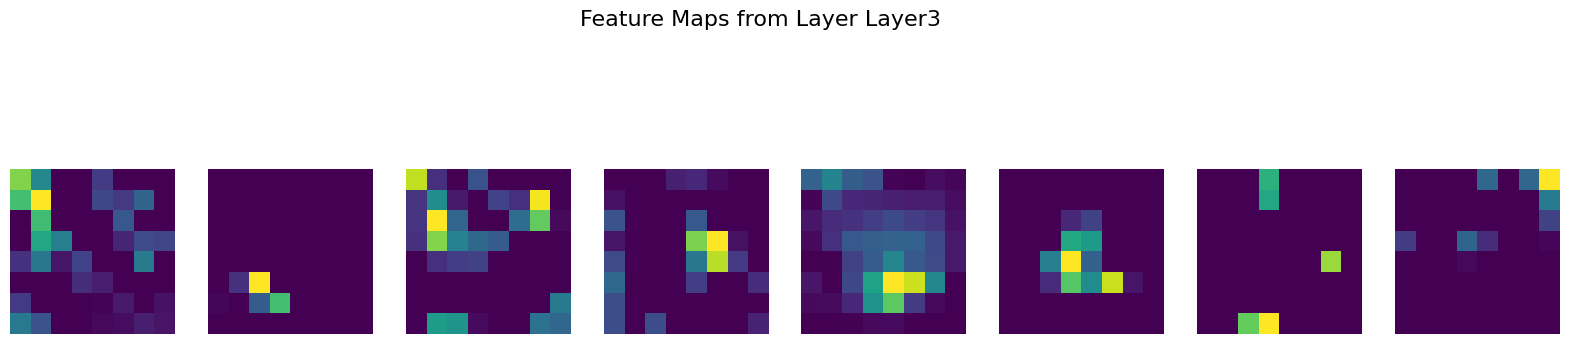

0.0004
Epoch 36/70
Iteración 12355 - Lote 35/352 - Pérdida de Entrenamiento: 0.1026, Precisión de Entrenamiento: 0.9661
Iteración 12390 - Lote 70/352 - Pérdida de Entrenamiento: 0.1084, Precisión de Entrenamiento: 0.9643
Iteración 12425 - Lote 105/352 - Pérdida de Entrenamiento: 0.1067, Precisión de Entrenamiento: 0.9643
Iteración 12460 - Lote 140/352 - Pérdida de Entrenamiento: 0.1062, Precisión de Entrenamiento: 0.9641
Iteración 12495 - Lote 175/352 - Pérdida de Entrenamiento: 0.1090, Precisión de Entrenamiento: 0.9631
Iteración 12530 - Lote 210/352 - Pérdida de Entrenamiento: 0.1092, Precisión de Entrenamiento: 0.9629
Iteración 12565 - Lote 245/352 - Pérdida de Entrenamiento: 0.1100, Precisión de Entrenamiento: 0.9628
Iteración 12600 - Lote 280/352 - Pérdida de Entrenamiento: 0.1107, Precisión de Entrenamiento: 0.9622
Iteración 12635 - Lote 315/352 - Pérdida de Entrenamiento: 0.1119, Precisión de Entrenamiento: 0.9619
Iteración 12670 - Lote 350/352 - Pérdida de Entrenamiento: 0.1118

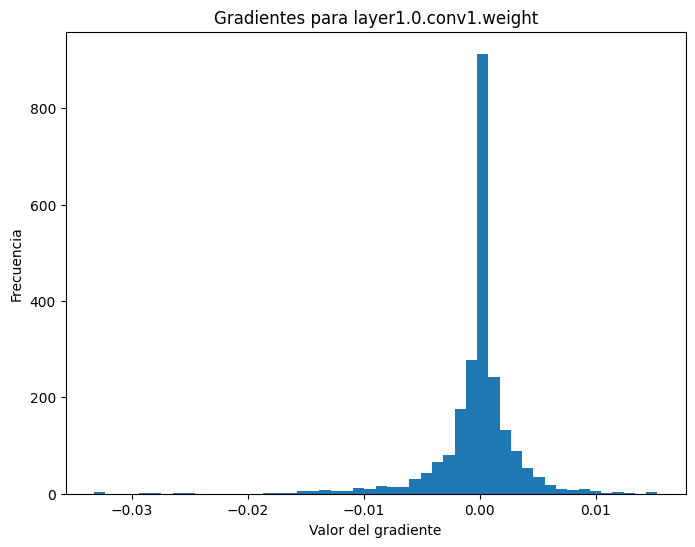

Gradientes para layer1.0.bn1.weight: min=-0.02502593956887722, max=0.019562115892767906, mean=-0.0009029329521581531, std=0.010142550803720951


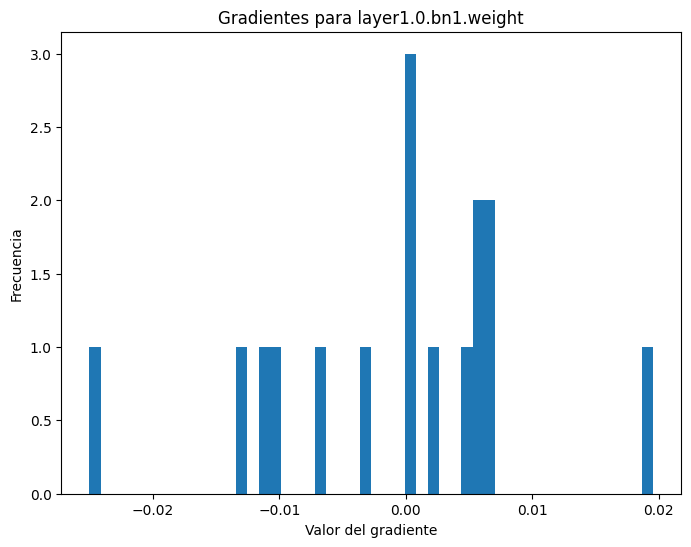

Gradientes para layer1.0.bn1.bias: min=-0.006615485064685345, max=0.02075488120317459, mean=0.001577798742800951, std=0.006983117200434208


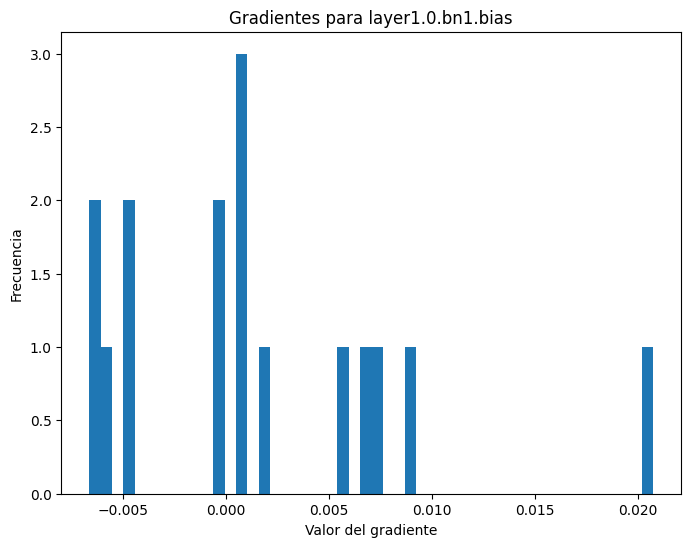

Gradientes para layer2.8.conv1.weight: min=-0.006237937603145838, max=0.0076547544449567795, mean=-2.684732316993177e-05, std=0.0011720149777829647


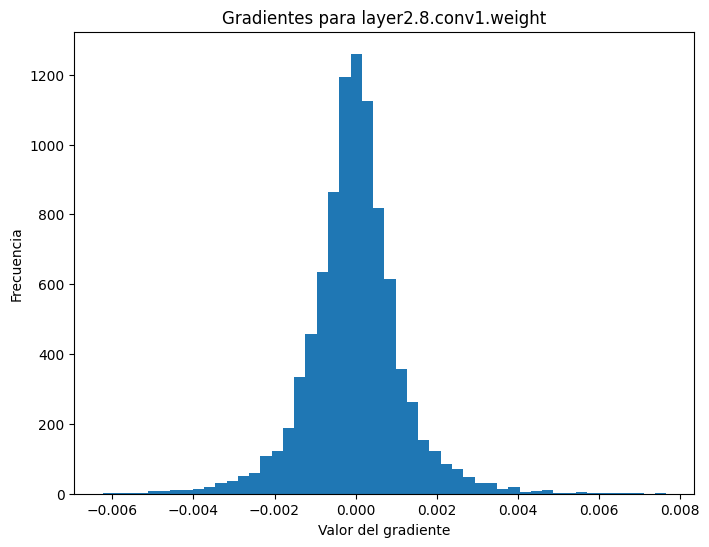

Gradientes para layer2.8.bn1.weight: min=-0.0043241241946816444, max=0.003871865337714553, mean=5.4276431910693645e-05, std=0.001812213915400207


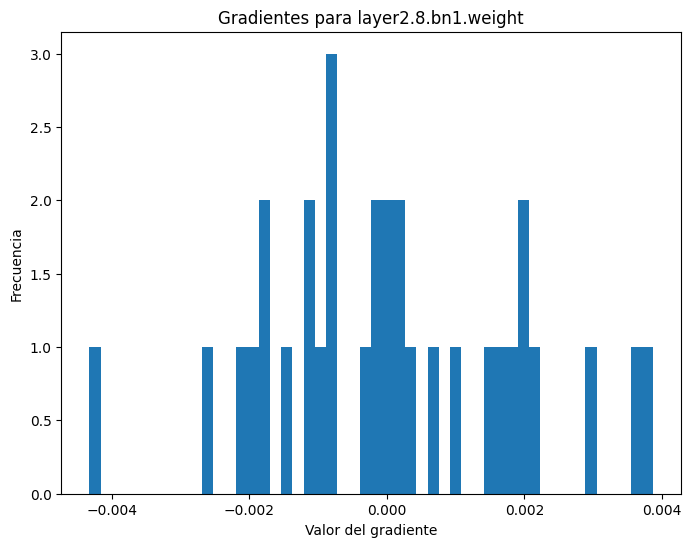

Gradientes para layer2.8.bn1.bias: min=-0.00456082820892334, max=0.004816453903913498, mean=0.0003461374144535512, std=0.0026361558120697737


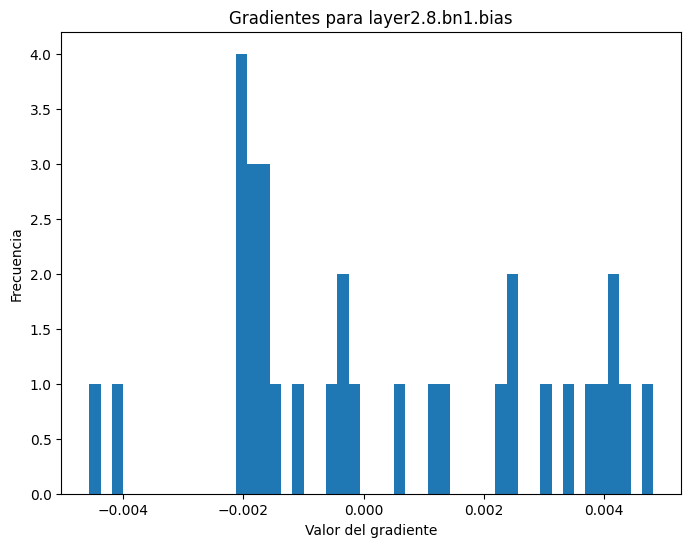

Gradientes para linear.weight: min=-0.05973311886191368, max=0.04987355321645737, mean=1.3038515822572094e-09, std=0.008680738508701324


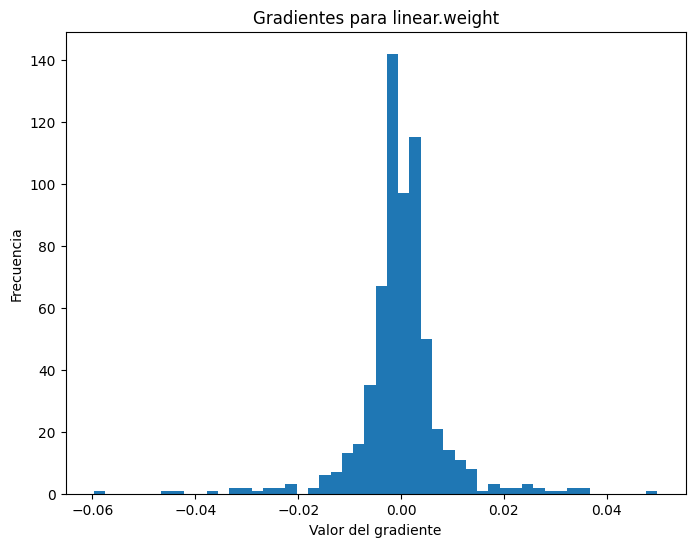

Gradientes para linear.bias: min=-0.01967882364988327, max=0.017639391124248505, mean=2.1886079615285325e-09, std=0.011290962807834148


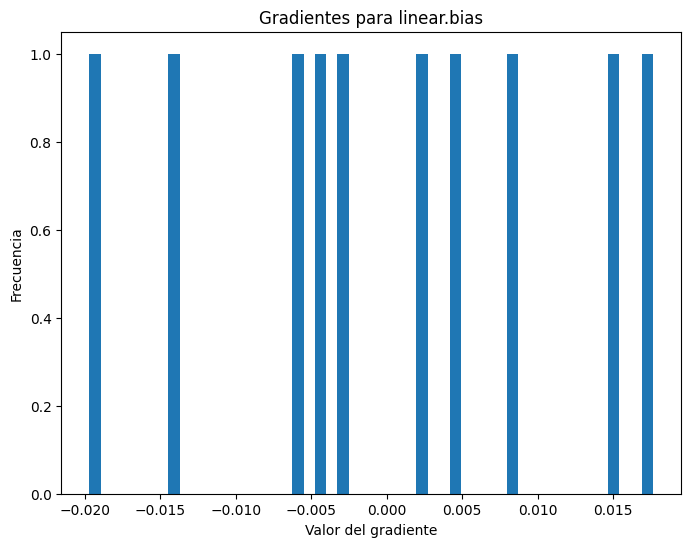

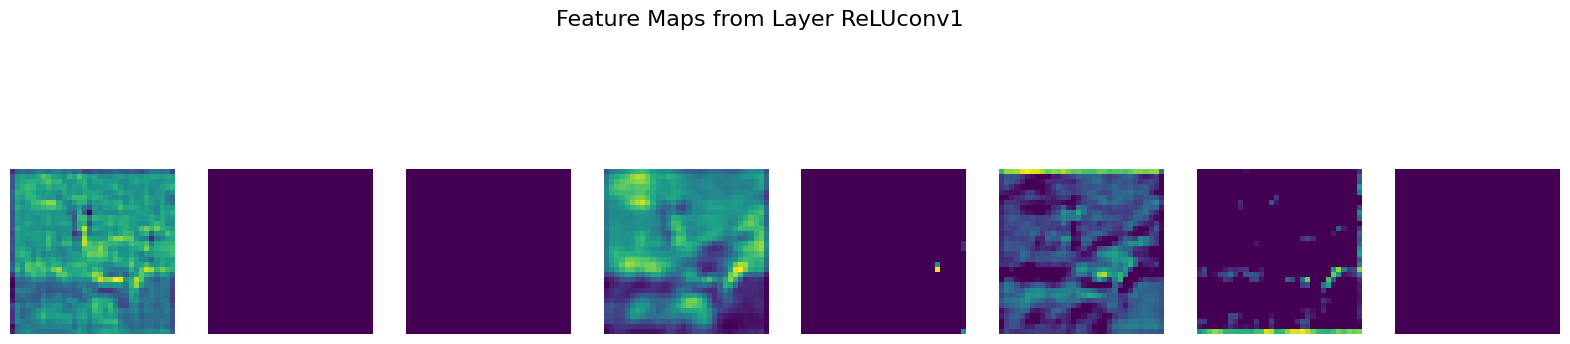

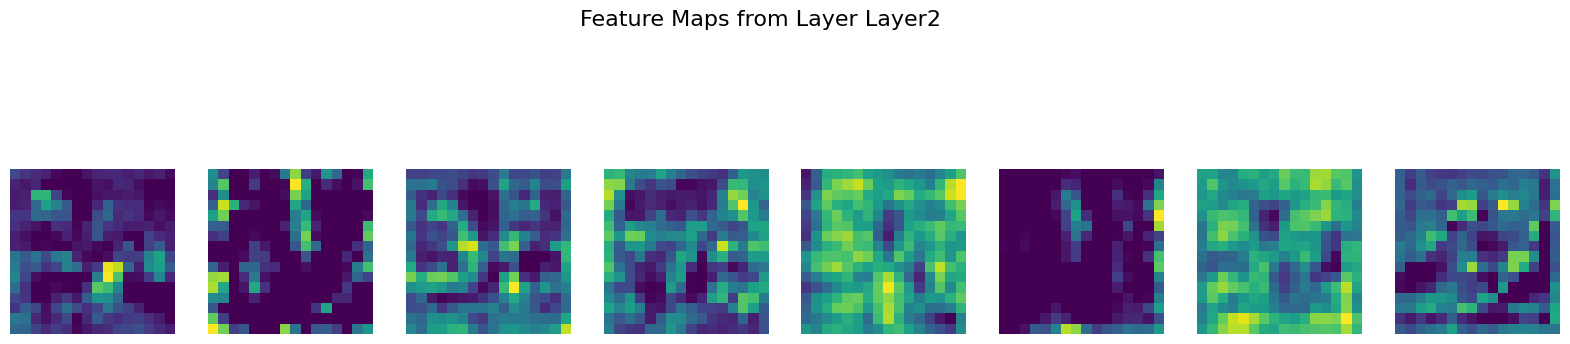

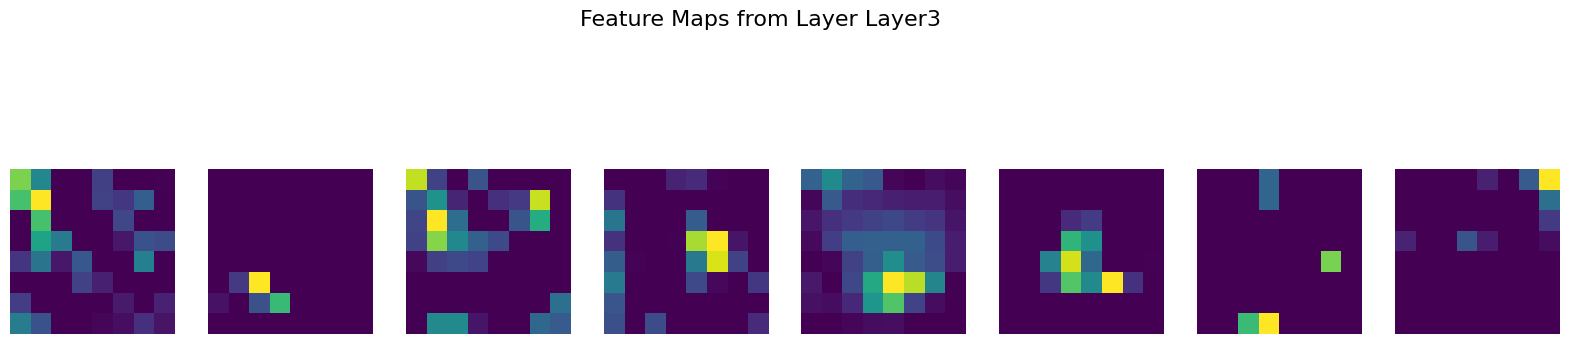

4.000000000000001e-06
Epoch 41/70
Iteración 14115 - Lote 35/352 - Pérdida de Entrenamiento: 0.1106, Precisión de Entrenamiento: 0.9645
Iteración 14150 - Lote 70/352 - Pérdida de Entrenamiento: 0.1128, Precisión de Entrenamiento: 0.9624
Iteración 14185 - Lote 105/352 - Pérdida de Entrenamiento: 0.1149, Precisión de Entrenamiento: 0.9612
Iteración 14220 - Lote 140/352 - Pérdida de Entrenamiento: 0.1138, Precisión de Entrenamiento: 0.9613
Iteración 14255 - Lote 175/352 - Pérdida de Entrenamiento: 0.1135, Precisión de Entrenamiento: 0.9618
Iteración 14290 - Lote 210/352 - Pérdida de Entrenamiento: 0.1135, Precisión de Entrenamiento: 0.9618
Iteración 14325 - Lote 245/352 - Pérdida de Entrenamiento: 0.1145, Precisión de Entrenamiento: 0.9616
Iteración 14360 - Lote 280/352 - Pérdida de Entrenamiento: 0.1148, Precisión de Entrenamiento: 0.9617
Iteración 14395 - Lote 315/352 - Pérdida de Entrenamiento: 0.1143, Precisión de Entrenamiento: 0.9618
Iteración 14430 - Lote 350/352 - Pérdida de Entren

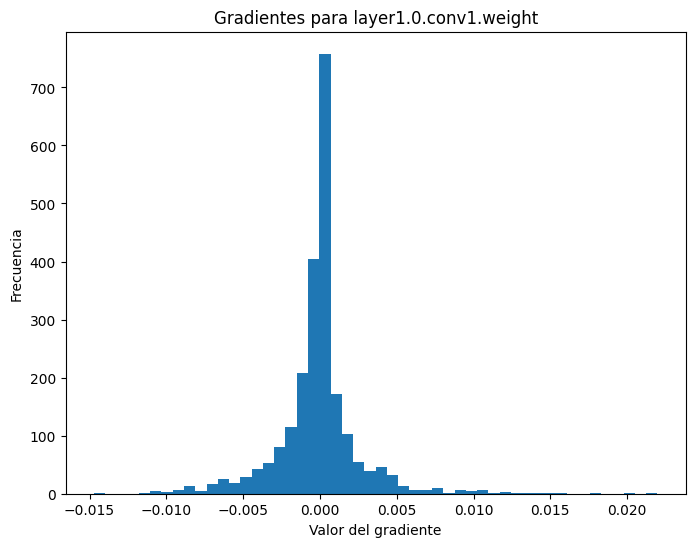

Gradientes para layer1.0.bn1.weight: min=-0.016770046204328537, max=0.02916916087269783, mean=0.002163337077945471, std=0.011654719710350037


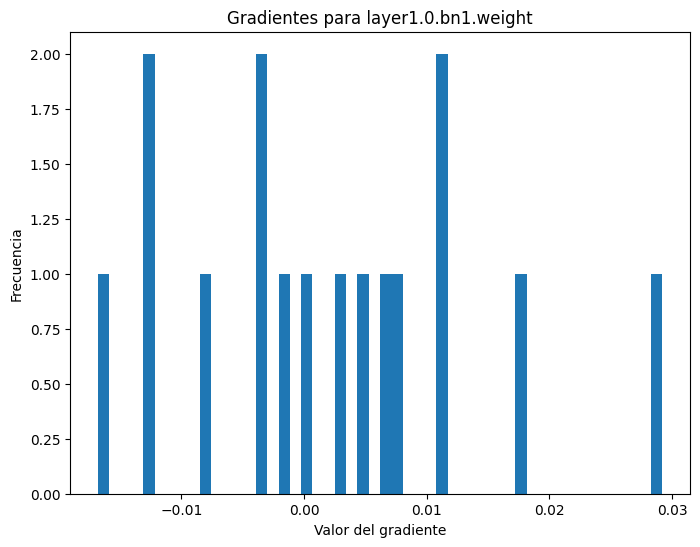

Gradientes para layer1.0.bn1.bias: min=-0.02808469533920288, max=0.022830255329608917, mean=0.0004182364500593394, std=0.010904389433562756


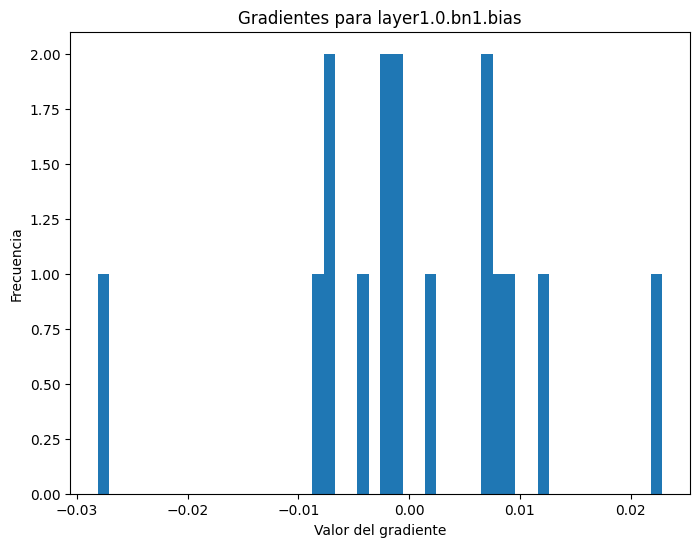

Gradientes para layer2.8.conv1.weight: min=-0.00786451157182455, max=0.012433246709406376, mean=-6.0417882195906714e-05, std=0.0013537391787394881


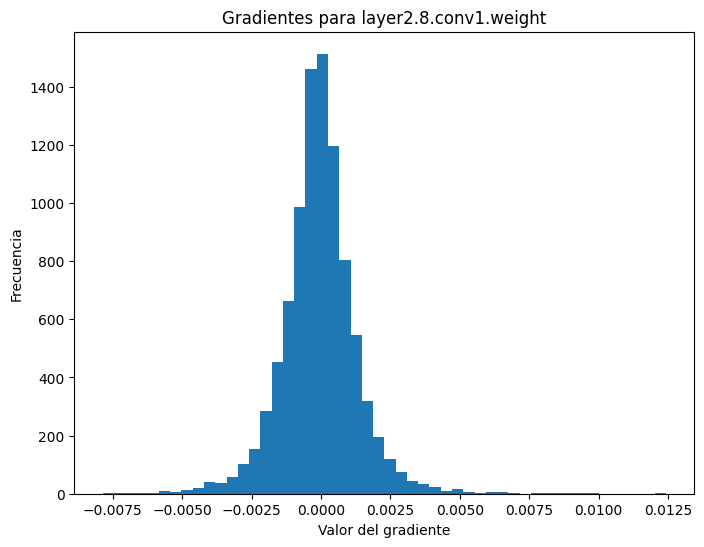

Gradientes para layer2.8.bn1.weight: min=-0.0063818227499723434, max=0.008349829353392124, mean=-5.994331149850041e-05, std=0.0032939515076577663


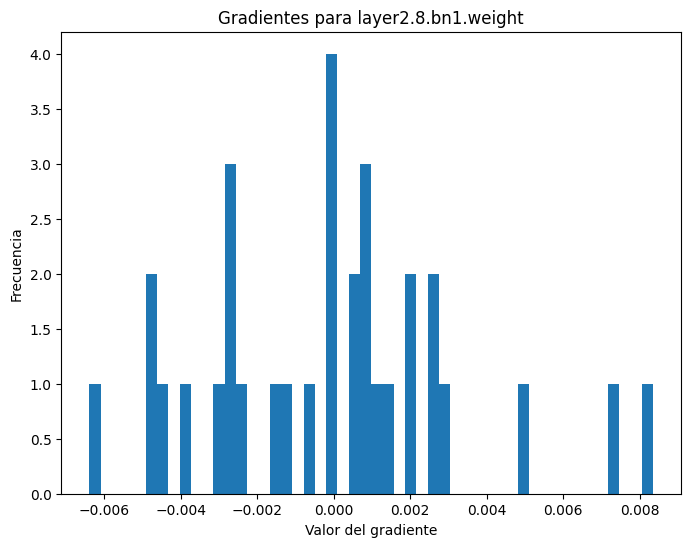

Gradientes para layer2.8.bn1.bias: min=-0.005720023065805435, max=0.005772113800048828, mean=-0.00015304391854442656, std=0.0029653043020516634


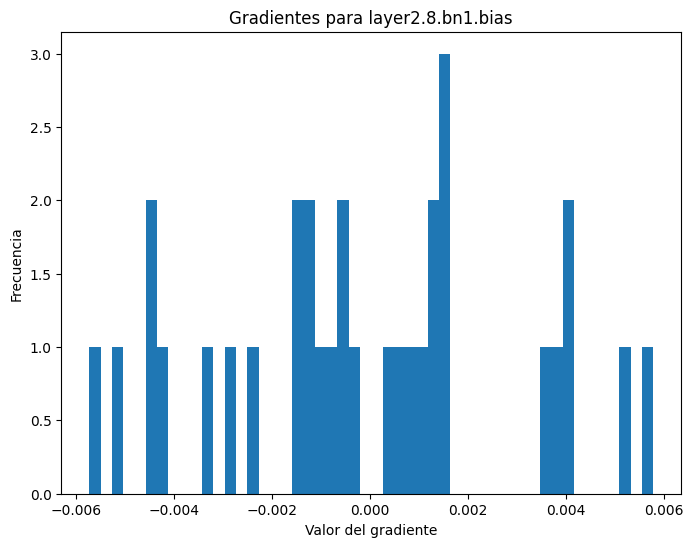

Gradientes para linear.weight: min=-0.08150069415569305, max=0.06251396983861923, mean=5.587935669737476e-10, std=0.012289161793887615


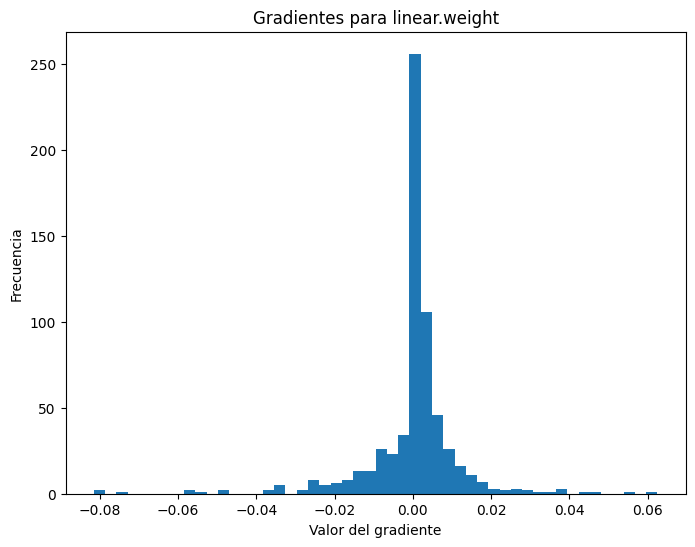

Gradientes para linear.bias: min=-0.03654920682311058, max=0.0242321714758873, mean=5.413312575974771e-10, std=0.017631523311138153


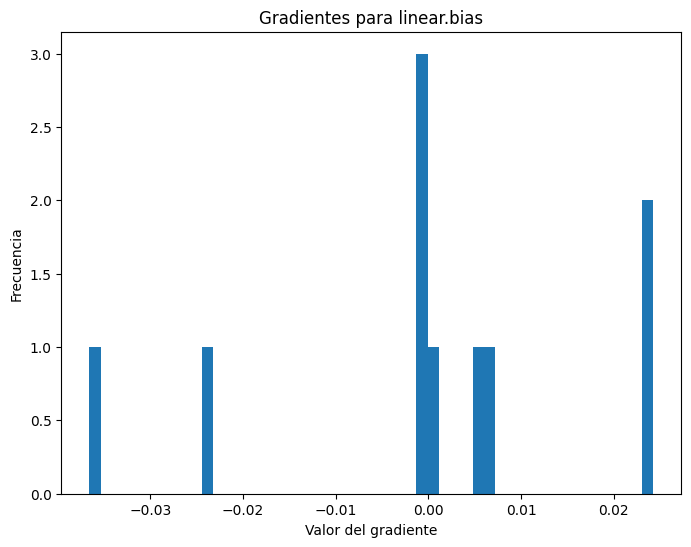

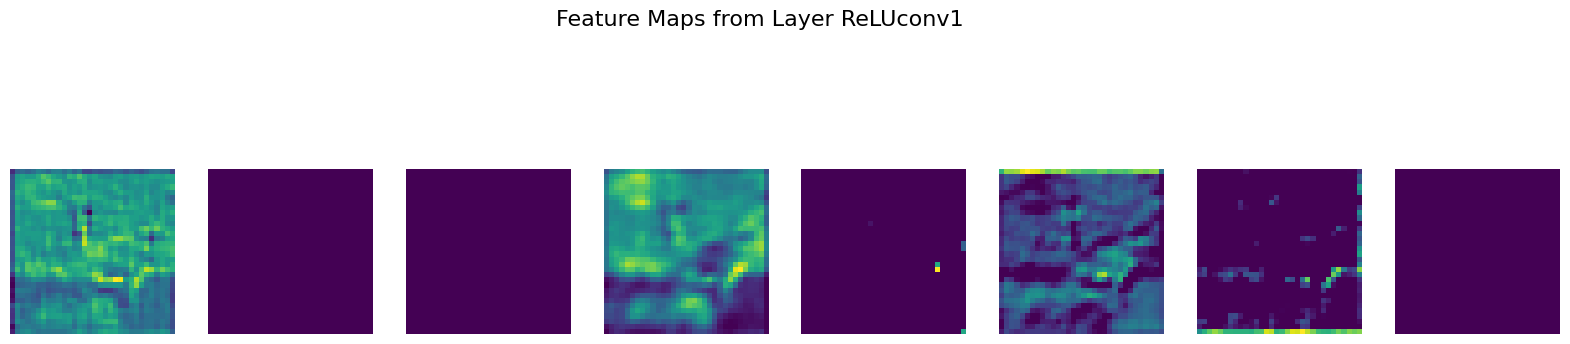

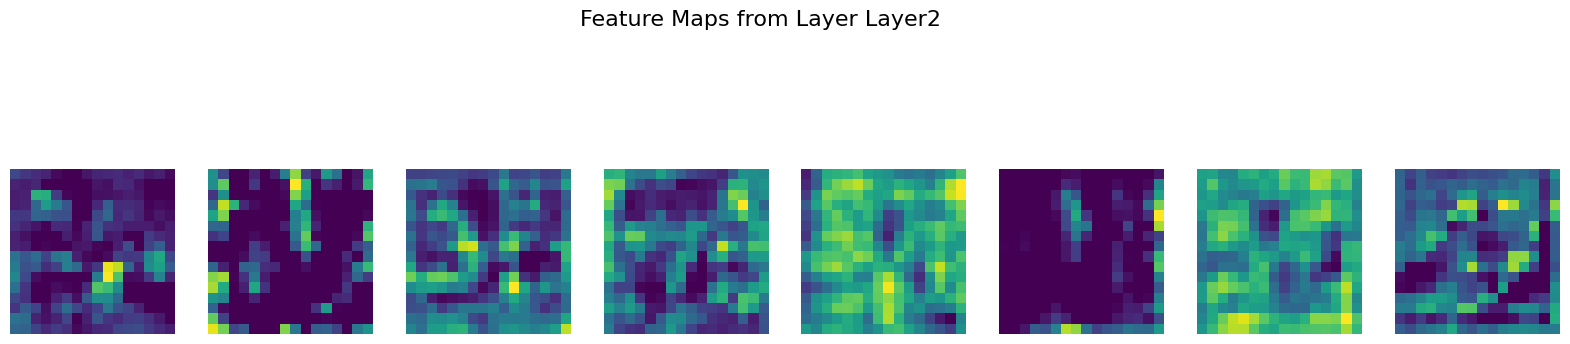

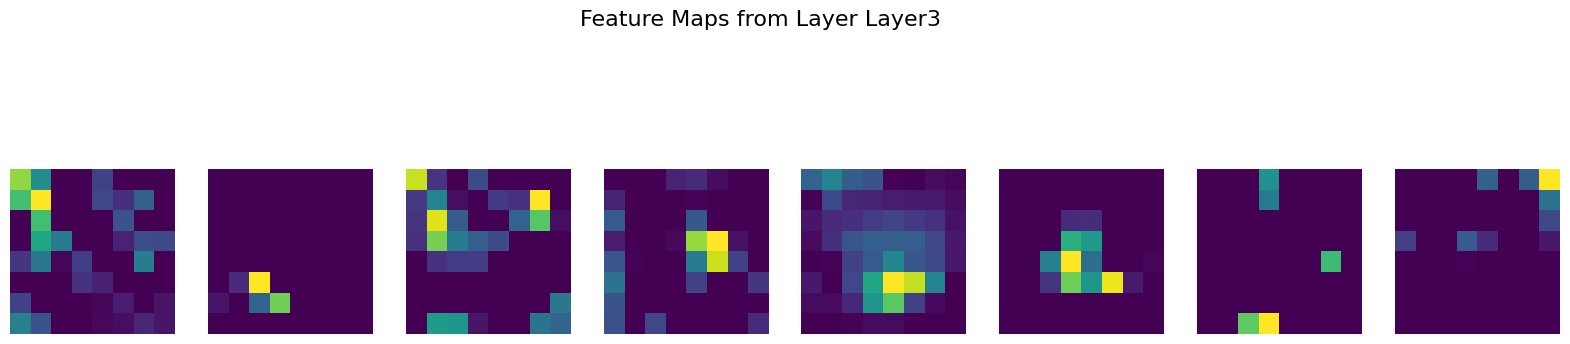

Early stopping at epoch 43

Tiempo total de entrenamiento: 2909.21 segundos


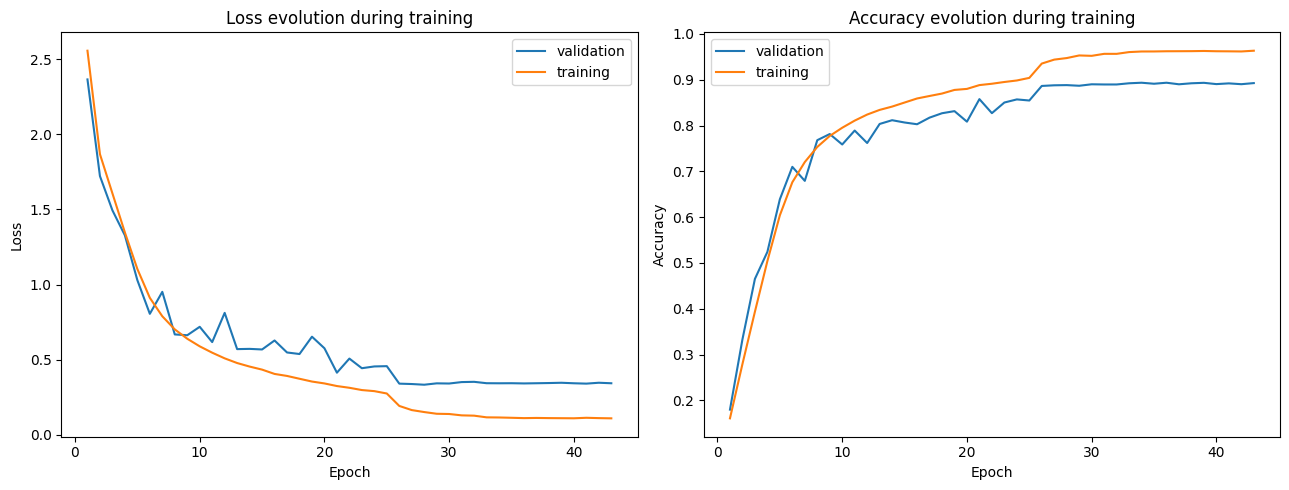

In [ ]:
use_gpu = True

# Checkpointing functions
checkpoint_dir = "/content/drive/MyDrive/CheckpointsResNet110"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 70
    max_iterations = 600000  # Ajusta según sea necesario
    learning_rate = 0.04
    n_evaluations_per_epoch = 10
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-4
    early_stop_thresh = 15
    patience = 3

    # Inicializar el modelo
    model = resnet110()

    print(model)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    # Entrenar el modelo
    curves = train_model(
        model=model,
        train_dataset=train_cifar10,
        val_dataset=val_cifar10,
        epochs=epochs,
        max_iterations=max_iterations,
        criterion=criterion,
        batch_size=batch_size,
        lr=learning_rate,
        n_evaluations_per_epoch=n_evaluations_per_epoch,
        early_stop_thresh=early_stop_thresh,
        show_gradients=show_gradients_ResNet_110,
        patience=patience,
        use_gpu=use_gpu,
        data_augmentation=data_augmentation,
        resume_checkpoint=None,  # Establece a una cadena de caracteres para reanudar, por ejemplo, "best_checkpoint_epoch_10.pth"
        weight_decay=weight_decay
    )

    # Plotear curvas de entrenamiento
    show_curves(curves)

### Visualizacion de la estructura, conexiones, complejidad y parametros

In [4]:
!pip install ptflops
!pip install torchinfo

In [5]:
import os
import sys
import time
import math
import copy
from math import ceil
from datetime import datetime
from functools import partial
from typing import Any, Callable, List, Optional, Sequence, Union
from dataclasses import dataclass
from io import StringIO

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from ptflops import get_model_complexity_info
from torchinfo import summary
import matplotlib.pyplot as plt
from google.colab import drive

In [9]:
# Función para imprimir estructura del modelo
def print_model_structure(model, indent=0):
    """Imprime la estructura del modelo mostrando las conexiones entre capas."""
    for name, child in model.named_children():
        print('  ' * indent + f'└─ {name}')
        if list(child.children()):
            print_model_structure(child, indent + 1)
        else:
            params = sum(p.numel() for p in child.parameters())
            print('  ' * (indent + 1) + f'└─ Parameters: {params:,}')

def test(net, checkpoint_path=None):
    # Crear un archivo de texto con la fecha y hora actual
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"model_analysis_{timestamp}.txt"

    # Redirigir la salida estándar a una cadena
    old_stdout = sys.stdout
    output_buffer = StringIO()
    sys.stdout = output_buffer

    try:
        # Cargar el mejor modelo
        if checkpoint_path and os.path.exists(checkpoint_path):
            print(f"Cargando el mejor modelo desde: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            net.load_state_dict(checkpoint['model_state_dict'])
            print(f"Modelo cargado de la época: {checkpoint['epoch']}")
        else:
            print("Usando modelo sin entrenar")

        # Mover el modelo a CPU para análisis
        net = net.cpu()
        net.eval()

        print("\n" + "="*50)
        print("ANÁLISIS DEL MODELO")
        print("="*50)

        # Sumario detallado del modelo
        print("\nRESUMEN DETALLADO DEL MODELO:")
        print("-"*50)
        summary_str = str(summary(net,
                input_size=(1, 3, 32, 32),
                col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                col_width=20,
                row_settings=["var_names"],
                verbose=2))
        print(summary_str)

        # Estructura del modelo y conexiones
        print("\nESTRUCTURA DEL MODELO Y CONEXIONES:")
        print("-"*50)
        print_model_structure(net)

        # No hay MBConv en este modelo, así que omitimos el análisis de conexiones residuales específicas de MBConv

        # Calcular FLOPs y parámetros
        print("\nANÁLISIS DE COMPLEJIDAD:")
        print("-"*50)
        macs, params = get_model_complexity_info(
            net,
            (3, 32, 32),
            as_strings=True,
            print_per_layer_stat=True,
            verbose=True
        )

        print(f'\nComplejidad computacional total: {macs}')
        print(f'Número total de parámetros: {params}')

        # Guardar toda la información en el archivo
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(output_buffer.getvalue())

        print(f"\nAnálisis guardado en: {output_file}")

    finally:
        # Restaurar la salida estándar
        sys.stdout = old_stdout

if __name__ == "__main__":
    # Crear el modelo
    model = resnet110()

    # Definir la ruta del directorio de checkpoints (ajusta según tu entorno)
    checkpoint_dir = "/content/drive/MyDrive/CheckpointsResNet110"
    best_checkpoint = None
    best_epoch = -1

    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            if filename.startswith('best_checkpoint_epoch_'):
                try:
                    epoch = int(filename.split('_')[-1].split('.')[0])
                    if epoch > best_epoch:
                        best_epoch = epoch
                        best_checkpoint = filename
                except ValueError:
                    pass

    if best_checkpoint:
        checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
        print(f"Encontrado mejor checkpoint: {best_checkpoint}")
    else:
        checkpoint_path = None
        print("No se encontró ningún checkpoint, se analizará el modelo sin entrenamiento.")

    # Ejecutar el test
    test(model, checkpoint_path)


Encontrado mejor checkpoint: best_checkpoint_epoch_28.pth


<ipython-input-9-a4d22f0af399>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


ResNet(
  1.73 M, 100.000% Params, 254.99 MMac, 99.589% MACs, 
  (conv1): Conv2d(432, 0.025% Params, 442.37 KMac, 0.173% MACs, 3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, 0.002% Params, 32.77 KMac, 0.013% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    84.1 k, 4.867% Params, 86.11 MMac, 33.633% MACs, 
    (0): BasicBlock(
      4.67 k, 0.270% Params, 4.78 MMac, 1.868% MACs, 
      (conv1): Conv2d(2.3 k, 0.133% Params, 2.36 MMac, 0.921% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, 0.002% Params, 32.77 KMac, 0.013% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(2.3 k, 0.133% Params, 2.36 MMac, 0.921% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, 0.002% Params, 32.77 KMac, 0.013% MACs, 16, eps=1e-05, momentum=0.1, affi

### Test

In [11]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "/content/drive/MyDrive/CheckpointsResNet110"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

model = resnet110()

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Preparar el conjunto de prueba y el DataLoader


val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Cargar el conjunto de prueba MNIST
test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=val_test_transform  # Transformaciones para testing
)

# Crear el DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(
    test_cifar10,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)



# Definir la función para evaluar TOP1 y TOP5
def evaluate_topk(loader, model, device, k=(1, 5)):
    model.eval()
    topk_accs = [0] * len(k)
    data_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(k), dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for i, kk in enumerate(k):
                correct_k = correct[:kk].reshape(-1).float().sum(0, keepdim=True)
                topk_accs[i] += correct_k.item()
            data_count += labels.size(0)
    topk_accs = [acc / data_count for acc in topk_accs]
    return topk_accs

# Evaluar el modelo en el conjunto de prueba
top1_acc, top5_acc = evaluate_topk(test_loader, model, device, k=(1, 5))

print(f"Precisión TOP1 en el conjunto de prueba: {top1_acc * 100:.2f}%")
print(f"Precisión TOP5 en el conjunto de prueba: {top5_acc * 100:.2f}%")


Mejor modelo encontrado: best_checkpoint_epoch_28.pth


<ipython-input-11-d0a03c4d5884>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Files already downloaded and verified
Precisión TOP1 en el conjunto de prueba: 89.11%
Precisión TOP5 en el conjunto de prueba: 99.55%


### UMAP y TSNE


In [12]:
!pip install umap-learn
import seaborn as sns
import umap.umap_ as umap

In [13]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "/content/drive/MyDrive/CheckpointsResNet110"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

model = resnet110()

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

Mejor modelo encontrado: best_checkpoint_epoch_28.pth


<ipython-input-13-a607c490432f>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


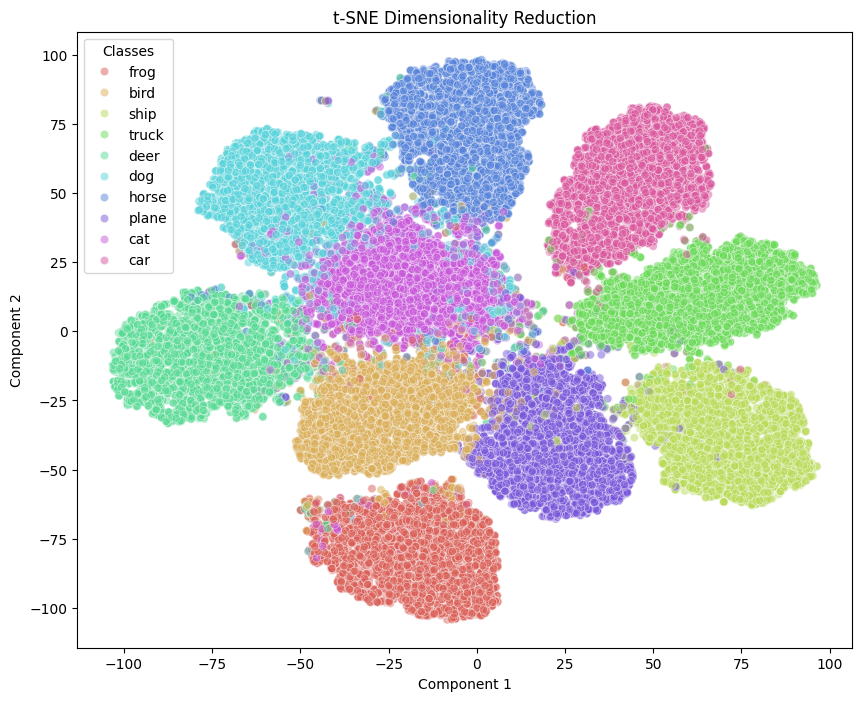

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


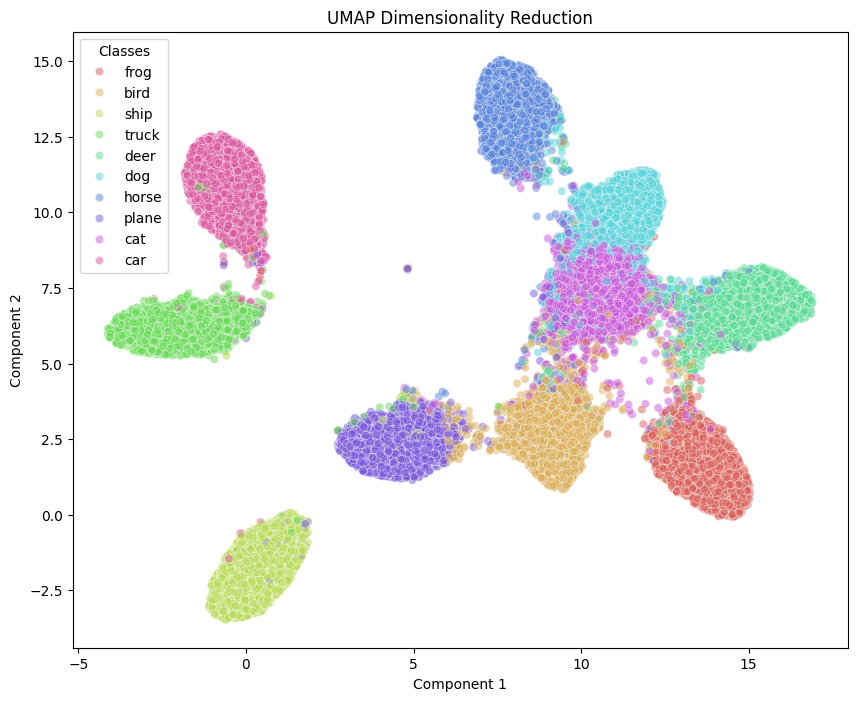

In [16]:
if use_gpu:
    model.cuda()

def get_embeddings(model, dataloader, use_gpu):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            if use_gpu:
                imgs = imgs.cuda()
            # Extraer características pasando las imágenes por el modelo
            # Ajusta estos pasos dependiendo de tu arquitectura
            features = F.relu(model.bn1(model.conv1(imgs)))
            features = model.layer1(features)
            features = model.layer2(features)
            features = model.layer3(features)
            features = model.avgpool(features)
            features = torch.flatten(features, 1)
            features = model.linear(features)
            embeddings.append(features.cpu())
            labels.append(lbls)

    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

full_train_loader = torch.utils.data.DataLoader(
    train_cifar10, batch_size=128, shuffle=False, num_workers=2, pin_memory=use_gpu
)

embeddings, labels = get_embeddings(model, full_train_loader, use_gpu)
embeddings_np = embeddings.numpy()
labels_np = labels.numpy()

#  Convertir etiquetas numéricas a nombres de clases
class_labels = [classes[label] for label in labels_np]

# Visualización con t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1],
    hue=class_labels, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('t-SNE Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()

# Visualización con UMAP
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
embeddings_umap = umap_reducer.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embeddings_umap[:, 0], y=embeddings_umap[:, 1],
    hue=class_labels, palette=sns.color_palette("hls", 10),
    legend="full", alpha=0.5
)
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Classes')
plt.show()